# Final Project: Natural Language Processing
### March 2021

### Environment Setup

In [1]:
import sys
sys.version

'3.7.10 (default, Feb 20 2021, 21:17:23) \n[GCC 7.5.0]'

In [7]:
# check for GPU 
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sat Mar 20 19:49:24 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Packages for all analyses

In [3]:
#!pip install wordcloud

In [2]:
import os
import pandas as pd
import numpy as np
import re
import string
import time
import math
import random
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.pyplot import figure
import warnings
import nltk as nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS 
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
warnings.simplefilter('ignore')

In [3]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

NER Packages

In [4]:
import spacy 
from spacy import displacy
import difflib

In [5]:
#!python -m spacy download en_core_web_lg

LDA packages

In [10]:
#%pip install pyLDAvis
#%pip install gensim

In [9]:
import gensim
from gensim import corpora, models
from gensim.models.ldamulticore import LdaMulticore
import pyLDAvis.gensim
import warnings
import multiprocessing
import tensorflow as tf

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


Zero-Shot Packages

In [23]:
#%pip install ktrain
#%pip install --upgrade ktrain

In [14]:
import ktrain
from ktrain import text
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx

#warnings.simplefilter('ignore')

/usr/local/lib/python3.7/dist-packages/packaging/version.py:130: DeprecationWarning: Creating a LegacyVersion has been deprecated and will be removed in the next major release
  DeprecationWarning,


Snorkel Packages

In [22]:
#!pip install snorkel

In [19]:
from tqdm.auto import tqdm
tqdm.pandas()
import snorkel as sk
from snorkel.labeling import labeling_function, PandasLFApplier, LFAnalysis, \
                            LabelingFunction, filter_unlabeled_dataframe
from snorkel.labeling.model.label_model import LabelModel
from snorkel.labeling.model.baselines import MajorityLabelVoter
from snorkel.analysis import get_label_buckets
from snorkel.preprocess import preprocessor
from snorkel.labeling.lf.nlp import nlp_labeling_function
from snorkel.utils import probs_to_preds

/usr/local/lib/python3.7/dist-packages/snorkel/map/core.py:3: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Hashable


In [11]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [12]:
pd.set_option('display.max_colwidth', 650)

### Data Cleaning

In [37]:
# read in data
df = pd.read_json('/content/drive/My Drive/news_chicago_il.json', lines=True)

In [ ]:
# preview
df.head()

crawled_date  ...                                                                                                                 title
0  1589155200000  ...                                                                                                       All In Illinois
1  1589155200000  ...                              The Illinois Department of Public Health Announces 1,656 New Cases; 57 Additional Deaths
2  1589155200000  ...                                                                                          Foto Friday: Alton, Illinois
3  1589155200000  ...                                  Chris Broussard on Michael Jordan returning to the Chicago Bulls in the 94-95 season
4  1589155200000  ...  Pork chops vs. people: Can Americans’ appetite for meat be filled without risking workers’ safety? - Chicago Tribune

[5 rows x 4 columns]

In [ ]:
# Filter english articles
df = df[df['language'] == 'english']

In [ ]:
# remove special characters, URLs, and HTML

df['text'] = df['text'].map(lambda x: re.sub('[^a-zA-Z0-9 @ . , : - _]', '', str(x)))
df['text'] = df['text'].map(lambda x: re.sub(r'http\S+', '', str(x)))
df['text'] = df['text'].map(lambda x: re.sub('<[^<]+?>', '', x))

df['title'] = df['title'].map(lambda x: re.sub('[^a-zA-Z0-9 @ . , : - _]', '', str(x)))
df['title'] = df['title'].map(lambda x: re.sub(r'http\S+', '', str(x)))
df['title'] = df['title'].map(lambda x: re.sub('<[^<]+?>', '', x))

In [ ]:
# create variables to assess length of text and title columns
df['length'] = df['text'].str.len()
df['article_len'] = df['title'].str.len()

In [ ]:
# Describe length of title and text 
df.describe()

crawled_date         length    article_len
count  3.730690e+05  373069.000000  373069.000000
mean   1.597888e+12    2259.085590      76.275424
std    9.120391e+09    3243.830987     209.160563
min    1.582070e+12       0.000000       0.000000
25%    1.590106e+12     389.000000      54.000000
50%    1.597622e+12    1332.000000      67.000000
75%    1.605571e+12    3188.000000      87.000000
max    1.613606e+12   99535.000000   78771.000000

In [ ]:
# Omit outliers 
df = df[df.article_len < df.article_len.quantile(.99)]
df = df[df.length < df.length.quantile(.99)]

Text(0.5, 1.0, 'Length of Articles')

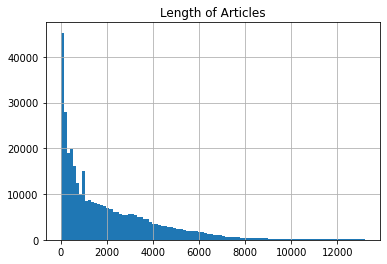

In [ ]:
# Show distribution of article text length. Note long tail
df['length'].hist(bins=100)
plt.title('Length of Articles')

Text(0.5, 1.0, 'Length of Title')

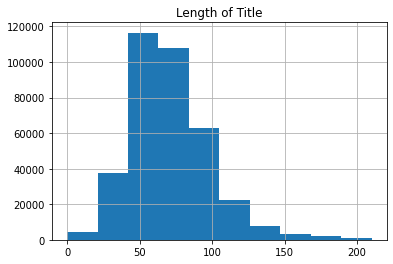

In [ ]:
# Show distribution of title length. Note relatively normally ditributed 
df['article_len'].hist(bins=10)
plt.title('Length of Title')

In [ ]:
# Change option to show more rows
pd.options.display.max_rows = 50

In [ ]:
# Evaluate articles with length less than 100 characters 
df[df['length'] <= 100].head(50)

crawled_date language  ... length article_len
19   1589155200000  english  ...     73          32
37   1589155200000  english  ...     36          61
38   1589155200000  english  ...     27          55
40   1589155200000  english  ...     36          51
43   1589155200000  english  ...     47          32
46   1589155200000  english  ...     24         110
56   1589155200000  english  ...     35          49
60   1589155200000  english  ...     80          78
87   1589155200000  english  ...     77          56
121  1589155200000  english  ...     64          67
124  1589155200000  english  ...     79          57
140  1589155200000  english  ...     98         198
146  1589155200000  english  ...     84          53
167  1589155200000  english  ...     49          80
169  1589155200000  english  ...     92          34
176  1589155200000  english  ...     80          97
177  1589155200000  english  ...     96         115
178  1589155200000  english  ...     65          84
179  1589155200000  english  ...     94         111
180  1589155200000  english  ...     92         109
181  1589155200000  english  ...     95         112
182  1589155200000  english  ...     90         107
190  1589155200000  english  ...     66          60
215  1589155200000  english  ...     36          35
280  1589155200000  english  ...      1          12
284  1589155200000  english  ...      1          10
371  1589155200000  english  ...     69         159
382  1589155200000  english  ...     74          62
394  1589155200000  english  ...     80          79
422  1589155200000  english  ...    100          42
435  1589155200000  english  ...     76          75
438  1589155200000  english  ...      1          64
447  1589155200000  english  ...     64          62
452  1589155200000  english  ...     43          42
458  1589155200000  english  ...     14          51
477  1589155200000  english  ...     44         113
541  1589155200000  english  ...     79          78
557  1589155200000  english  ...     23          22
587  1589155200000  english  ...     90         106
588  1589155200000  english  ...     67          90
589  1589155200000  english  ...     45          65
614  1589155200000  english  ...     87          37
619  1589155200000  english  ...     22          19
638  1589155200000  english  ...     73          36
641  1589155200000  english  ...     71          71
701  1589241600000  english  ...     61          36
707  1589241600000  english  ...     75          24
718  1589241600000  english  ...     35          29
721  1589241600000  english  ...     87          40
770  1589241600000  english  ...     58          57

[50 rows x 6 columns]

In [ ]:
# Omit articles with length less than 100 characters 
df = df[df['length'] >= 100]
len(df)

328786

In [ ]:
# show duplicate values
df[df.duplicated(subset='text')].sort_values(by='text').head(50)

crawled_date language  ... length article_len
197363  1593734400000  english  ...    650         107
235095  1610928000000  english  ...    650          70
178267  1598572800000  english  ...    650          93
119827  1603497600000  english  ...    650          77
119700  1603497600000  english  ...    650          84
197365  1593734400000  english  ...    650         119
197364  1593734400000  english  ...    650         123
226668  1608336000000  english  ...    650          91
256579  1612483200000  english  ...   1053          59
213439  1585440000000  english  ...   1569          64
153468  1597104000000  english  ...    694         111
366317  1583107200000  english  ...    297          62
366315  1583107200000  english  ...    297          53
366215  1583020800000  english  ...    297          66
366316  1583107200000  english  ...    297          51
300491  1582416000000  english  ...    297          56
147557  1583280000000  english  ...    297          24
88560   1582848000000  english  ...    297          59
194300  1583625600000  english  ...    297          60
178684  1588377600000  english  ...    297          58
300492  1582416000000  english  ...    297          98
366372  1583107200000  english  ...    297          80
156684  1583452800000  english  ...    297          65
366314  1583107200000  english  ...    297          55
158782  1588204800000  english  ...    296          65
124749  1584748800000  english  ...    296          65
281789  1587945600000  english  ...    296          45
216016  1583107200000  english  ...    296          52
51865   1599177600000  english  ...    334          61
51814   1599177600000  english  ...    334          66
338737  1594598400000  english  ...    334          42
363770  1594684800000  english  ...    334          62
273037  1601251200000  english  ...    334          46
354737  1595462400000  english  ...    334          44
367771  1602460800000  english  ...    334          47
120103  1603584000000  english  ...    334          68
324126  1595203200000  english  ...    334          67
322393  1598400000000  english  ...    334          45
122162  1594425600000  english  ...    334          45
337808  1601510400000  english  ...    334          83
307625  1603929600000  english  ...    334          65
16134   1593648000000  english  ...    334          57
312473  1602460800000  english  ...    334          58
83280   1601769600000  english  ...    334          61
106195  1604534400000  english  ...    334          69
338805  1594684800000  english  ...    334          75
107176  1604793600000  english  ...    334          66
180103  1599350400000  english  ...    334          78
107542  1604880000000  english  ...    334          63
168574  1597968000000  english  ...    334          65

[50 rows x 6 columns]

In [ ]:
# Drop duplicates based on both text and title columns
df.drop_duplicates(subset ="text", keep = 'first', inplace = True) 
df.drop_duplicates(subset="title", keep='first', inplace=True) 
len(df)

225109

In [ ]:
df = df[df['article_len'] >0]

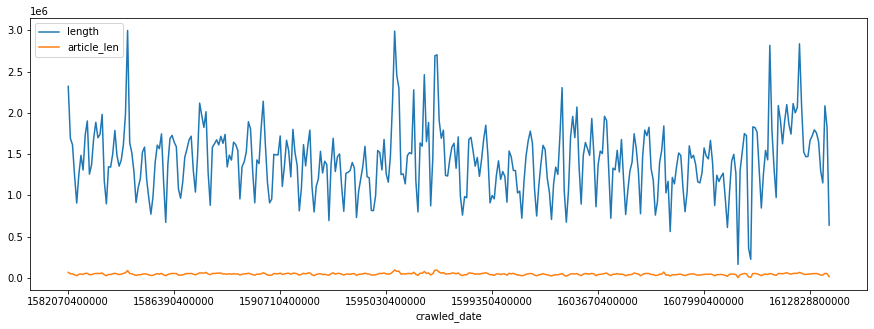

In [ ]:
# assess crawl date for any obvious abnormalities
df['crawled_date'] = df['crawled_date'].astype(str)
df.groupby('crawled_date').sum().plot(figsize=(15,5))

In [ ]:
#Preview cleaned data
df.head()

crawled_date language  ... length article_len
0  1589155200000  english  ...   5960          15
1  1589155200000  english  ...    784          87
2  1589155200000  english  ...    464          28
3  1589155200000  english  ...   1311          83
4  1589155200000  english  ...    500         112

[5 rows x 6 columns]

In [ ]:
# Note deletion of approx 150k records 
len(df)

225108

In [ ]:
# Store cleaned dataframe
df.to_csv('NLP_final_cleandf.csv')

!cp NLP_final_cleandf.csv "/content/drive/My Drive/"

### Small Sample

Data was sampled in order to complete preliminary Named Entity Recognition and topic modelling. This was essential for both understanding the structure of the data, themes, and for developing a strategy for full analyses. 

In [ ]:
# Sample 100 cases
small_sample = df.sample(n=1000, random_state=1)

In [ ]:
# Preview
small_sample.head()

crawled_date language  ... length article_len
9104    1590969600000  english  ...   2818          71
214325  1608076800000  english  ...   1396          70
242838  1611532800000  english  ...   5947          73
159057  1588204800000  english  ...   2123         107
244412  1611705600000  english  ...   1390          37

[5 rows x 6 columns]

In [ ]:
# Save in drive 
small_sample.to_csv('NLP_final_sample_1000.csv')

!cp NLP_final_sample_1000.csv "/content/drive/My Drive/"

### Exploratory Data Analysis - Named Entity Recognition 



In [ ]:
# Read in previously stored data 
df = pd.read_csv('/content/drive/My Drive/NLP_final_cleandf.csv', index_col=0)
small_sample = pd.read_csv('/content/drive/My Drive/NLP_final_sample_1000.csv', index_col=0)

In [ ]:
# Use medium pre-trained spacy model 
nlp = spacy.load("en_core_web_lg")

In [ ]:
# Conduct Named Entity Recognition (NER) for text column 
entities = []
labels = []

for i in small_sample['text'].tolist():
    doc = nlp(i)
    for ent in doc.ents:
        entities.append(ent.text)
        labels.append(ent.label_)
        
len(entities)

In [ ]:
# Read in stored NER data
#ner_df = pd.read_csv('/content/drive/My Drive/ner_df.csv', index_col=0)

In [ ]:
# Save output as dataframe, sample output 
ner_df = pd.DataFrame({'Entities':entities,'Labels':labels})
ner_df

Entities    Labels
0                              21  CARDINAL
1                             two  CARDINAL
2                      last night      TIME
3                              14      DATE
4                  7:07:07 AM PDT      TIME
...                           ...       ...
40620                    Chicagos       ORG
40621                     Chicago       GPE
40622  Chicagobased CNA Financial       ORG
40623               one degree or  QUANTITY
40624                    billions  CARDINAL

[40625 rows x 2 columns]

In [ ]:
# Aggregate results for each category type, sort in descending order.
categories = pd.DataFrame(np.unique(ner_df['Labels'], return_counts=True)).T.sort_values(by=1, ascending=False)
categories

0     1
11          ORG  8807
0      CARDINAL  7637
1          DATE  7137
13       PERSON  6615
4           GPE  5344
16         TIME   939
10      ORDINAL   723
3           FAC   630
9          NORP   623
7           LOC   599
14      PRODUCT   295
15     QUANTITY   286
17  WORK_OF_ART   273
2         EVENT   253
8         MONEY   176
12      PERCENT   143
6           LAW   130
5      LANGUAGE    15

In [ ]:
# Explain unnknown categories 
print(spacy.explain('CARDINAL'))
print(spacy.explain('GPE'))
print(spacy.explain('NORP'))
print(spacy.explain('FAC'))
print(spacy.explain('LOC'))

Numerals that do not fall under another type
Countries, cities, states
Nationalities or religious or political groups
Buildings, airports, highways, bridges, etc.
Non-GPE locations, mountain ranges, bodies of water


In [ ]:
# Select relevant category types and aggregate results. Note significant replication, lack of normalized entities. 
entities = ner_df[ner_df.Labels.isin(['ORG','PERSON','NORP','PRODUCT','WORK_OF_ART','EVENT'])]
entities['Total'] = 1
entities = entities.groupby(['Entities']).sum('Total').sort_values(by='Total', ascending=False)
entities.head(20)

Total
Entities                                     
Illinois Tool Works                       135
Pritzker                                  106
Cubs                                       83
Trump                                      77
the Illinois Department of Corrections     76
Midwest Real Estate Data LLC               74
Broker Reciprocity                         73
MRED                                       73
Lightfoot                                  68
Lori Lightfoot                             67
Facebook                                   56
the Illinois Comptroller Office            55
J.B. Pritzker                              55
Bears                                      54
Bulls                                      54
Strauss                                    53
CDC                                        50
NBA                                        49
NFL                                        48
ITW                                        47

In [ ]:
# Normalize entity names
entities = entities.reset_index()
entities.loc[entities['Entities'].str.contains("Pritzker"), 'Entities'] = 'Pritzker'
entities.loc[entities['Entities'].str.contains("Facebook"), 'Entities'] = 'Facebook'
entities.loc[entities['Entities'].str.contains("Lightfoot"), 'Entities'] = 'Lightfoot'
entities.loc[entities['Entities'].str.contains("COVID"), 'Entities'] = 'COVID'
entities.loc[entities['Entities'].str.contains("Trump"), 'Entities'] = 'Trump'
entities.loc[entities['Entities'].str.contains("Tribune"), 'Entities'] = 'Chicago Tribune'
entities.loc[entities['Entities'].str.contains("Democrat"), 'Entities'] = 'Democrat'
entities.loc[entities['Entities'].str.contains("Republican"), 'Entities'] = 'Republican'
entities.loc[entities['Entities'].str.contains("CPS"), 'Entities'] = 'Chicago Public Schools'
entities = entities.groupby(['Entities']).sum('Total').sort_values(by='Total', ascending=False)

In [ ]:
# This was revised after later stage analysis. Note irrelevance of certain named entites. These were later omitted in the 'Full Data Topic Modelling..." section
small_sample[small_sample['text'].str.contains('Illinois Tool Works')].sample(3)

crawled_date language  ... length article_len
268504  1596326400000  english  ...   5443          74
28359   1609891200000  english  ...   4999          78
213652  1585526400000  english  ...   5158          77

[3 rows x 6 columns]

In [ ]:
#Preview
small_sample[small_sample['text'].str.contains('Midwest Real Estate Data LLC')].sample(3)

crawled_date language  ... length article_len
96057   1587686400000  english  ...    959          48
175762  1584057600000  english  ...    963          49
359539  1589500800000  english  ...    960          59

[3 rows x 6 columns]

In [ ]:
# Preview MRED
small_sample[small_sample['text'].str.contains('MRED')].sample(3)

crawled_date language  ... length article_len
292374  1582243200000  english  ...    955          48
79314   1613520000000  english  ...    956          52
147154  1583280000000  english  ...    963          49

[3 rows x 6 columns]

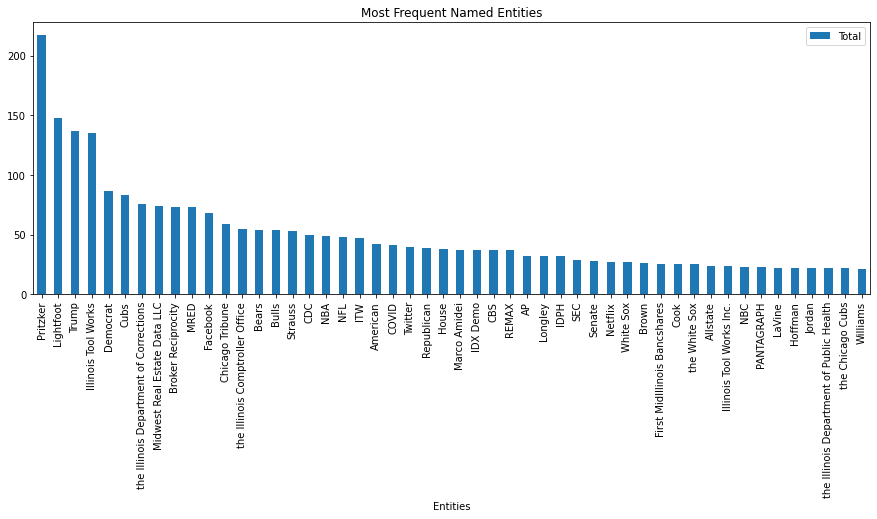

In [ ]:
# Visualize most frequent named entites. Note prominence of key political figures - Pritzker, Lightfoot, Trump, as well as sports teams/entities and news sources. 
entities.head(50).plot.bar(figsize=(15,5), title="Most Frequent Named Entities");

In [ ]:
# save results 
ner_df.to_csv('ner_df.csv')

!cp ner_df.csv "/content/drive/My Drive/"

In [ ]:
# Conduct Named Entity Recognition (NER) on the title column 
entities = []
labels = []

for i in small_sample['title'].tolist():
    doc = nlp(i)
    for ent in doc.ents:
        entities.append(ent.text)
        labels.append(ent.label_)
        
# Total of 2,568 entities extracted from article title 
len(entities)

2568

In [ ]:
# Save output as dataframe, sample output 
ner_df2 = pd.DataFrame({'Entities':entities,'Labels':labels})
ner_df2

Entities  Labels
0                 Chicago     GPE
1       Illinois Football     ORG
2                    2021    DATE
3          Daniel Edwards  PERSON
4     Chicago Capital LLC     ORG
...                   ...     ...
2563               SCOTUS     ORG
2564            this year    DATE
2565             Illinois     GPE
2566          State Farms     ORG
2567                COVID     ORG

[2568 rows x 2 columns]

In [ ]:
# Summarize title categories 
categories2 = pd.DataFrame(np.unique(ner_df2['Labels'], return_counts=True)).T.sort_values(by=1, ascending=False)
categories2

0    1
4           GPE  851
10          ORG  619
12       PERSON  322
1          DATE  286
0      CARDINAL  284
11      PERCENT   37
7           LOC   34
2         EVENT   31
3           FAC   28
8          NORP   18
16  WORK_OF_ART   17
9       ORDINAL   13
15         TIME   11
13      PRODUCT    8
14     QUANTITY    5
6           LAW    3
5      LANGUAGE    1

In [ ]:
# Aggregate relevant named entities
entities2 = ner_df2[ner_df2.Labels.isin(['ORG','PERSON','NORP','PRODUCT','WORK_OF_ART','EVENT'])]
entities2['Total'] = 1
entities2 = entities2.groupby(['Entities']).sum('Total').sort_values(by='Total', ascending=False)
entities2.head(20)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Total
Entities                                                 
the Illinois Department of Corrections                 30
Chicago Bulls                                          11
Pritzker                                               10
ITW                                                     8
Chicago Cubs                                            7
Chicago Partners Investment Group LLC                   7
Illinois Tool Works Inc. NYSE                           6
COVID                                                   6
the Illinois Department of Transportation               6
Trump                                                   6
Coronavirus                                             5
the Illinois Department of Human Services               5
the Illinois Department of Healthcare                   5
White Sox                                               5
Lightfoot                                               4
Biden                                                   4
the Illinois Department of Children and Family ...      4
Chicago Med                                             4
University of Chicago                                   4
Zach LaVine                                             3

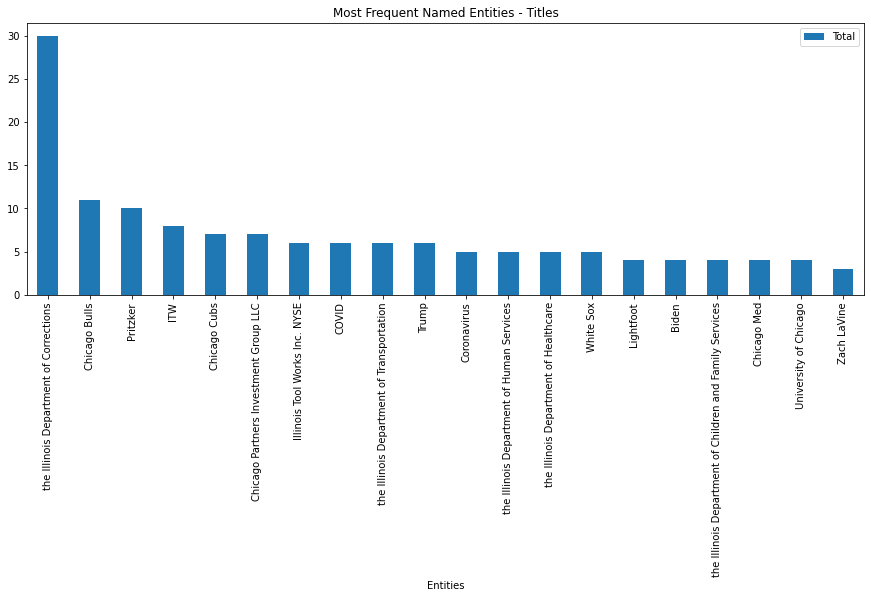

In [ ]:
# Ttile column is less illustrative than for text, but see many commonalities 
entities2.head(20).plot.bar(figsize=(15,5), title="Most Frequent Named Entities - Titles");

In [ ]:
# Note unusual frequency of Illinois Department of Corrections, deem it irrelevant 
small_sample[small_sample['title'].str.contains('the Illinois Department of Corrections')].head(5)

crawled_date language  ... length article_len
268676  1596326400000  english  ...    553          98
196187  1598918400000  english  ...    512          94
114115  1596153600000  english  ...    432          91
157636  1593907200000  english  ...    301          90
157497  1593907200000  english  ...    475         102

[5 rows x 6 columns]

In [ ]:
# remove rows 
df = df[~df['title'].str.contains('the Illinois Department of Corrections')]

In [ ]:
# current df length 
len(df)

220260

In [ ]:
# save/replace cleaned dataframe given new deletion
df.to_csv('NLP_final_cleandf.csv')

!cp NLP_final_cleandf.csv "/content/drive/My Drive/"

### Exploratory Data Analysis - LDA

Next, LDA was completed to understand the different themes in the articles. However, since there is so much overlap between topics, LDA wasn't very illustrative, regardless of the topic size used. For example, COVID was relevant to crime, politics, business, etc. so parsing exact themes was a challenge.

It was also noted that LDA is quite computationally expensive, although not impossible. Therefore, LDA was completed on both text and title columns. 

In [13]:
# read in relevant data 
df = pd.read_csv('/content/drive/My Drive/NLP_final_cleandf.csv', index_col=0)
small_sample = pd.read_csv('/content/drive/My Drive/NLP_final_sample_1000.csv', index_col=0)

In [14]:
# Clean data further excluding stopwards, lemmatizing, removing punctuation

stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()
def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

In [15]:
# Create new clean data columns for both text and title 
small_sample['clean_text'] = [clean(doc).split() for doc in small_sample['text']]
small_sample['clean_title'] = [clean(doc).split() for doc in small_sample['title']]     

In [16]:
# preview
small_sample.head(5)

crawled_date  ...                                                                                                      clean_title
9104    1590969600000  ...                                                           [riot, chicago, broken, glass, like, shattered, dream]
214325  1608076800000  ...                                      [illinois, football, illini, sign, class, 2021, cornerback, daniel, edward]
242838  1611532800000  ...                                    [chicago, capital, llc, raise, position, alliance, data, system, co, nyseads]
159057  1588204800000  ...  [oprah, winfrey, give, commencement, address, chicago, public, school, citywide, virtual, graduation, ceremony]
244412  1611705600000  ...                                                                        [kit, chicago, blaze, 8, brenda, rothert]

[5 rows x 8 columns]

In [17]:
# Create term dictionary of our corpus, where every unique term is assigned an index. 
text_dictionary = corpora.Dictionary(small_sample['clean_text'])

# Convert list of documents (corpus) into Document Term Matrix 
text_term_matrix = [text_dictionary.doc2bow(doc) for doc in small_sample['clean_text']]

In [18]:
# Create term dictionary of our corpus, where every unique term is assigned an index. 
title_dictionary = corpora.Dictionary(small_sample['clean_title'])

# Convert list of documents (corpus) into Document Term Matrix 
title_term_matrix = [title_dictionary.doc2bow(doc) for doc in small_sample['clean_title']]

In [19]:
# Check number of processors 
num_processors = multiprocessing.cpu_count()
num_processors

2

In [20]:
# Create LDA model and report function  
def lda_out(term_matrix, dictionary, number, words):
    # Using LDA Multicore for faster processing 
    ldamodel = LdaMulticore(term_matrix, num_topics=number, id2word = dictionary, passes=50, workers = num_processors-1)
    
    topics = pd.DataFrame(ldamodel.print_topics(num_words=words)).rename(columns = {1: 'Most important words'})
    topics['Topic Class'] = range(1,number+1)
    topics = topics.drop(columns=0).set_index('Topic Class')
    
    lda_display = pyLDAvis.gensim.prepare(ldamodel, term_matrix, dictionary, sort_topics=False, mds='mmds')
    
    # Function returns the model, topics and variable used for the pyLDAavis visualization 
    return(ldamodel, topics, lda_display)

##### 3-Topic Model

In [21]:
# 3-topic model using text column 
%time text_model3, text_topics3, text_display3 = lda_out(text_term_matrix, text_dictionary, 3, 10)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt

CPU times: user 2min 30s, sys: 15.6 s, total: 2min 46s
Wall time: 2min 38s


In [22]:
# 3-topic model using title column 
%time title_model3, title_topics3, title_display3 = lda_out(title_term_matrix, title_dictionary, 3, 10)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt

CPU times: user 1min 1s, sys: 10.8 s, total: 1min 12s
Wall time: 1min 5s


In [23]:
# show most important words 
pd.DataFrame(text_topics3)

Most important words
Topic Class                                                                                                                                                                   
1                0.009*"illinois" + 0.006*"chicago" + 0.004*"game" + 0.004*"one" + 0.004*"state" + 0.004*"year" + 0.004*"season" + 0.003*"team" + 0.003*"county" + 0.003*"new"
2            0.014*"share" + 0.012*"company" + 0.009*"stock" + 0.008*"quarter" + 0.007*"rating" + 0.006*"illinois" + 0.006*"price" + 0.006*"work" + 0.005*"may" + 0.005*"tool"
3              0.011*"chicago" + 0.008*"said" + 0.005*"state" + 0.005*"illinois" + 0.004*"police" + 0.004*"people" + 0.004*"city" + 0.003*"one" + 0.003*"time" + 0.003*"would"

In [24]:
# show most important words 
pd.DataFrame(title_topics3)

Most important words
Topic Class                                                                                                                                                                                 
1            0.056*"chicago" + 0.038*"illinois" + 0.012*"department" + 0.012*"2019" + 0.011*"earns" + 0.010*"working" + 0.006*"percent" + 0.006*"2020" + 0.006*"correction" + 0.005*"police"
2                                  0.031*"illinois" + 0.030*"chicago" + 0.011*"2020" + 0.005*"sale" + 0.005*"home" + 0.004*"april" + 0.004*"news" + 0.004*"new" + 0.003*"man" + 0.003*"city"
3                     0.043*"chicago" + 0.035*"illinois" + 0.009*"covid19" + 0.009*"new" + 0.009*"coronavirus" + 0.008*"case" + 0.007*"state" + 0.005*"death" + 0.005*"inc" + 0.005*"police"

In [25]:
# display text model 
pyLDAvis.display(text_display3)

In [26]:
# display title model 
pyLDAvis.display(title_display3)

##### 5-Topic Model

In [27]:
# create 5-topic model using text column 
%time text_model5, text_topics5, text_display5 = lda_out(text_term_matrix, text_dictionary, 5, 10)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt

CPU times: user 2min 28s, sys: 13.6 s, total: 2min 41s
Wall time: 2min 34s


In [28]:
# create 5-topic model using title column 
%time title_model5, title_topics5, title_display5 = lda_out(title_term_matrix, title_dictionary, 5, 10)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt

CPU times: user 56.2 s, sys: 9.56 s, total: 1min 5s
Wall time: 59.8 s


In [29]:
# show most important words 
pd.DataFrame(text_topics5)

Most important words
Topic Class                                                                                                                                                                           
1                          0.012*"chicago" + 0.008*"police" + 0.006*"said" + 0.005*"may" + 0.004*"city" + 0.004*"illinois" + 0.004*"real" + 0.004*"man" + 0.003*"estate" + 0.003*"one"
2                 0.013*"illinois" + 0.011*"share" + 0.010*"company" + 0.007*"stock" + 0.006*"quarter" + 0.006*"work" + 0.006*"rating" + 0.005*"state" + 0.005*"new" + 0.005*"covid19"
3                              0.009*"chicago" + 0.007*"game" + 0.006*"season" + 0.006*"one" + 0.005*"team" + 0.004*"year" + 0.004*"time" + 0.004*"like" + 0.004*"first" + 0.003*"get"
4            0.011*"said" + 0.010*"state" + 0.009*"chicago" + 0.009*"illinois" + 0.005*"people" + 0.005*"school" + 0.004*"city" + 0.004*"health" + 0.004*"would" + 0.004*"coronavirus"
5               0.013*"illinois" + 0.007*"department" + 0.006*"0" + 0.005*"working" + 0.004*"state" + 0.004*"chicago" + 0.004*"2019" + 0.004*"pay" + 0.004*"employee" + 0.004*"public"

In [30]:
# show most important words 
pd.DataFrame(title_topics5)

Most important words
Topic Class                                                                                                                                                                                   
1                                 0.078*"chicago" + 0.011*"illinois" + 0.008*"police" + 0.006*"man" + 0.005*"bear" + 0.004*"llc" + 0.004*"fire" + 0.004*"state" + 0.004*"group" + 0.004*"shot"
2                                     0.035*"chicago" + 0.022*"illinois" + 0.006*"police" + 0.005*"say" + 0.005*"2" + 0.005*"co" + 0.005*"7" + 0.003*"federal" + 0.003*"watch" + 0.003*"trust"
3            0.057*"illinois" + 0.027*"chicago" + 0.023*"2019" + 0.023*"department" + 0.022*"earns" + 0.020*"working" + 0.012*"percent" + 0.011*"correction" + 0.008*"service" + 0.007*"state"
4                                0.053*"illinois" + 0.032*"chicago" + 0.012*"new" + 0.012*"2020" + 0.008*"covid19" + 0.006*"white" + 0.006*"inc" + 0.005*"sale" + 0.005*"home" + 0.005*"first"
5                        0.052*"chicago" + 0.032*"illinois" + 0.008*"covid19" + 0.008*"case" + 0.006*"coronavirus" + 0.006*"2020" + 0.005*"year" + 0.005*"new" + 0.005*"state" + 0.005*"death"

In [31]:
# display text model
pyLDAvis.display(text_display5)

In [32]:
# display title model
pyLDAvis.display(title_display5)

##### 10-Topic Model

In [33]:
# Create 10-topic model with text column 
%time text_model10, text_topics10, text_display10 = lda_out(text_term_matrix, text_dictionary, 10, 10)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt

CPU times: user 2min 25s, sys: 11.2 s, total: 2min 36s
Wall time: 2min 32s


In [34]:
# Create 10-topic model with title column 
%time title_model10, title_topics10, title_display10 = lda_out(title_term_matrix, title_dictionary, 10, 10)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt

CPU times: user 50.6 s, sys: 8.36 s, total: 59 s
Wall time: 54.4 s


In [35]:
# show most important words for text column 
pd.DataFrame(text_topics10)

Most important words
Topic Class                                                                                                                                                                              
1                                    0.014*"chicago" + 0.006*"one" + 0.005*"city" + 0.005*"said" + 0.004*"people" + 0.004*"get" + 0.004*"like" + 0.004*"time" + 0.003*"would" + 0.003*"u"
2                   0.007*"illinois" + 0.006*"county" + 0.006*"chicago" + 0.005*"home" + 0.004*"state" + 0.004*"election" + 0.004*"covid19" + 0.004*"said" + 0.004*"people" + 0.004*"day"
3                    0.025*"share" + 0.018*"company" + 0.016*"stock" + 0.014*"quarter" + 0.013*"rating" + 0.010*"illinois" + 0.009*"price" + 0.009*"tool" + 0.009*"estate" + 0.009*"work"
4                   0.007*"chicago" + 0.006*"said" + 0.005*"school" + 0.005*"service" + 0.005*"illinois" + 0.005*"state" + 0.004*"health" + 0.004*"year" + 0.003*"student" + 0.003*"work"
5                    0.019*"illinois" + 0.016*"state" + 0.012*"case" + 0.011*"said" + 0.008*"covid19" + 0.007*"county" + 0.006*"pritzker" + 0.006*"health" + 0.005*"people" + 0.005*"new"
6            0.014*"illinois" + 0.013*"police" + 0.011*"chicago" + 0.009*"said" + 0.009*"department" + 0.007*"officer" + 0.007*"man" + 0.006*"shot" + 0.006*"working" + 0.005*"according"
7                             0.013*"game" + 0.009*"season" + 0.008*"team" + 0.007*"chicago" + 0.006*"player" + 0.005*"year" + 0.005*"bull" + 0.005*"first" + 0.005*"last" + 0.004*"2020"
8                                  0.010*"1" + 0.007*"male" + 0.007*"county" + 0.006*"new" + 0.005*"rate" + 0.005*"illinois" + 0.005*"female" + 0.005*"tax" + 0.004*"cub" + 0.004*"state"
9                          0.007*"1" + 0.006*"case" + 0.005*"number" + 0.005*"illinois" + 0.005*"death" + 0.005*"state" + 0.004*"covid19" + 0.004*"parish" + 0.003*"county" + 0.003*"cdc"
10                          0.013*"0" + 0.010*"chicago" + 0.008*"state" + 0.006*"match" + 0.006*"illinois" + 0.005*"basketball" + 0.004*"last" + 0.004*"1" + 0.004*"company" + 0.003*"co"

In [36]:
# show most important words for title column 
pd.DataFrame(title_topics10)

Most important words
Topic Class                                                                                                                                                                                   
1                                 0.046*"chicago" + 0.037*"illinois" + 0.008*"state" + 0.006*"co" + 0.005*"first" + 0.004*"holding" + 0.004*"city" + 0.003*"man" + 0.003*"nbc" + 0.003*"mayor"
2                            0.048*"chicago" + 0.031*"illinois" + 0.012*"coronavirus" + 0.007*"new" + 0.005*"may" + 0.005*"2020" + 0.004*"tax" + 0.004*"case" + 0.004*"officer" + 0.004*"fire"
3                         0.035*"illinois" + 0.035*"chicago" + 0.009*"police" + 0.007*"news" + 0.007*"trial" + 0.007*"7" + 0.004*"covid19" + 0.004*"online" + 0.004*"fund" + 0.004*"municipal"
4                       0.062*"chicago" + 0.017*"illinois" + 0.012*"police" + 0.008*"shot" + 0.007*"shooting" + 0.007*"killed" + 0.006*"people" + 0.006*"man" + 0.006*"wounded" + 0.006*"fire"
5                              0.027*"illinois" + 0.027*"chicago" + 0.007*"new" + 0.006*"2020" + 0.006*"tribune" + 0.005*"police" + 0.005*"state" + 0.004*"black" + 0.004*"day" + 0.004*"news"
6            0.059*"illinois" + 0.037*"chicago" + 0.031*"department" + 0.029*"earns" + 0.029*"2019" + 0.027*"working" + 0.017*"percent" + 0.015*"correction" + 0.008*"service" + 0.007*"state"
7                                 0.044*"chicago" + 0.028*"illinois" + 0.010*"2020" + 0.006*"city" + 0.005*"death" + 0.004*"covid19" + 0.004*"park" + 0.004*"trump" + 0.004*"news" + 0.003*"1"
8                           0.045*"chicago" + 0.036*"illinois" + 0.008*"inc" + 0.008*"llc" + 0.007*"work" + 0.007*"nyseitw" + 0.007*"tool" + 0.007*"covid19" + 0.006*"partner" + 0.006*"share"
9                                 0.060*"chicago" + 0.026*"illinois" + 0.008*"2020" + 0.006*"business" + 0.005*"case" + 0.005*"move" + 0.004*"may" + 0.004*"v" + 0.004*"news" + 0.004*"statue"
10                    0.048*"chicago" + 0.040*"illinois" + 0.020*"new" + 0.013*"case" + 0.011*"covid19" + 0.010*"2020" + 0.006*"coronavirus" + 0.005*"district" + 0.005*"april" + 0.005*"sale"

In [37]:
# display text model 
pyLDAvis.display(text_display10)

In [38]:
# display title model 
pyLDAvis.display(title_display10)

### Exploratory Data Analysis - Zero Shot Learning using NLI

Zero shot learning using NLI was extremely effective at capturing the themes that LDA hinted at. However, it is extremely computationally expensive, so the title column was also experimented with. It reduced processing time by ~16x. While the classification rate was lower, trends followed similar patterns and once article inspection was done, this was deemed a good solution. 

In [ ]:
# read in data
df = pd.read_csv('/content/drive/My Drive/NLP_final_cleandf.csv', index_col=0)
small_sample = pd.read_csv('/content/drive/My Drive/NLP_final_sample_1000.csv', index_col=0)

In [ ]:
# define labels. These were selected both by what had been previously observed in NER and LDA, and also by what I assumed to be helpful in understanding why someone would and would not want to live in Illinois. 
zsl = ktrain.text.ZeroShotClassifier()
labels = ['Chicago',
          'Illinois',
          'crime',
          'health',
          'business',
          'culture',
          'education', 
          'money',
          'family', 
          'entertainment',
          'food',
          'politics',
          'sports', 
          'film', 
          'nature',
          'tax',
          'diversity',
          'weather', 
          'home',
          'covid',
          'coronavirus',
          'protest', 
          'moving'
          ]


In [ ]:
# Send text column to list, fit model. Note it took 45 minutes for just 1000 articles. 
txt = small_sample['text'].tolist()
%time txt_predictions = zsl.predict(txt, labels=labels, include_labels=False, batch_size=64)

CPU times: user 21min 47s, sys: 23min 41s, total: 45min 28s
Wall time: 45min 11s


In [ ]:
# create labeled data frame
text_results = pd.DataFrame(txt_predictions)
text_results.columns = labels
text_results.head()

Chicago  Illinois     crime  ...     covid  coronavirus   protest
0  0.709733  0.518374  0.935422  ...  0.473750     0.027865  0.280554
1  0.228021  0.986059  0.057462  ...  0.851505     0.019256  0.011119
2  0.924326  0.858571  0.346667  ...  0.805486     0.282678  0.361304
3  0.973801  0.624302  0.056634  ...  0.880739     0.915507  0.248214
4  0.673337  0.067621  0.011137  ...  0.542399     0.009972  0.012665

[5 rows x 22 columns]

In [ ]:
# save results
text_results.to_csv('NLI_text_sample1000.csv')
!cp NLI_text_sample1000.csv "/content/drive/My Drive/"

In [ ]:
# Create title list, Fit model. Note it took just ~3 minutes 
titl = small_sample['title'].tolist()
%time title_predictions = zsl.predict(titl, labels=labels, include_labels=False, batch_size=64)

CPU times: user 1min 29s, sys: 1min 26s, total: 2min 56s
Wall time: 2min 55s


In [ ]:
# Create labeled dataframe
title_results = pd.DataFrame(title_predictions)
title_results.columns = labels

In [ ]:
# store
title_results.to_csv('NLI_title_sample1000.csv')
!cp NLI_title_sample1000.csv "/content/drive/My Drive/"

title_results.head()

Chicago  Illinois     crime  ...  coronavirus   protest    moving
0  0.994921  0.007409  0.950163  ...     0.002274  0.857522  0.175335
1  0.002679  0.996847  0.013947  ...     0.007640  0.024358  0.678632
2  0.982679  0.389290  0.019120  ...     0.012411  0.019608  0.782410
3  0.936207  0.034528  0.001933  ...     0.002968  0.008271  0.827434
4  0.986466  0.155385  0.741542  ...     0.010175  0.226632  0.234096

[5 rows x 23 columns]

In [ ]:
# read in dataframes
text_results = pd.read_csv('/content/drive/My Drive/NLI_text_sample1000.csv', index_col=0)
title_results = pd.read_csv('/content/drive/My Drive/NLI_title_sample1000.csv', index_col=0)

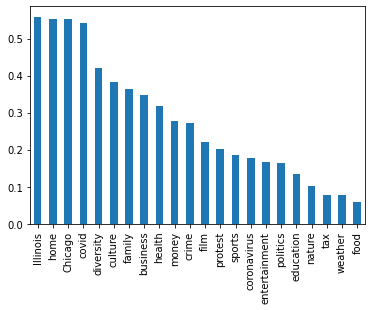

In [ ]:
# visualize mean value for each category. Note Illinois, home, Chicago, covid most common 
text_results.mean(axis=0).sort_values(ascending=False).plot.bar()

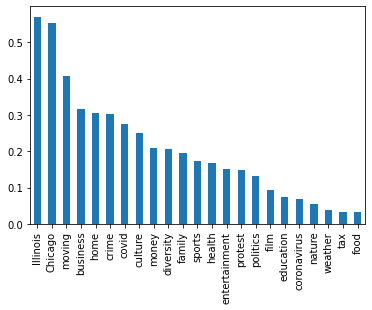

In [ ]:
# Visualize mean value for title column. Note lower mean scores overall, except for 'Chicago' and 'Illinois'
title_results.mean(axis=0).sort_values(ascending=False).plot.bar()

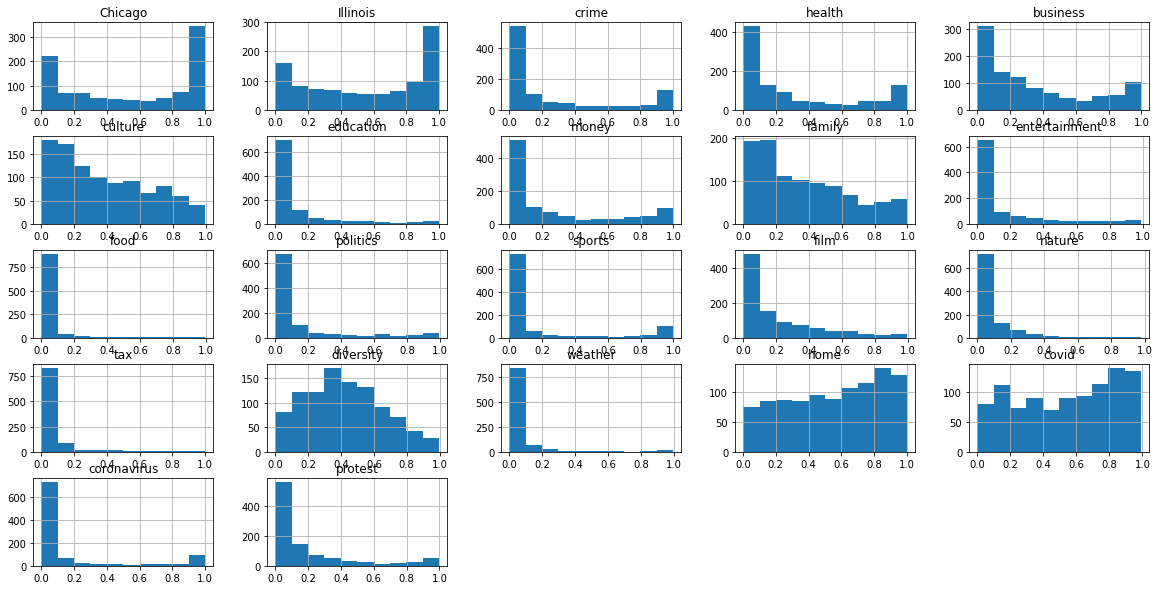

In [ ]:
# Visualize distribution for text column 
text_results.hist(figsize = (20,10));

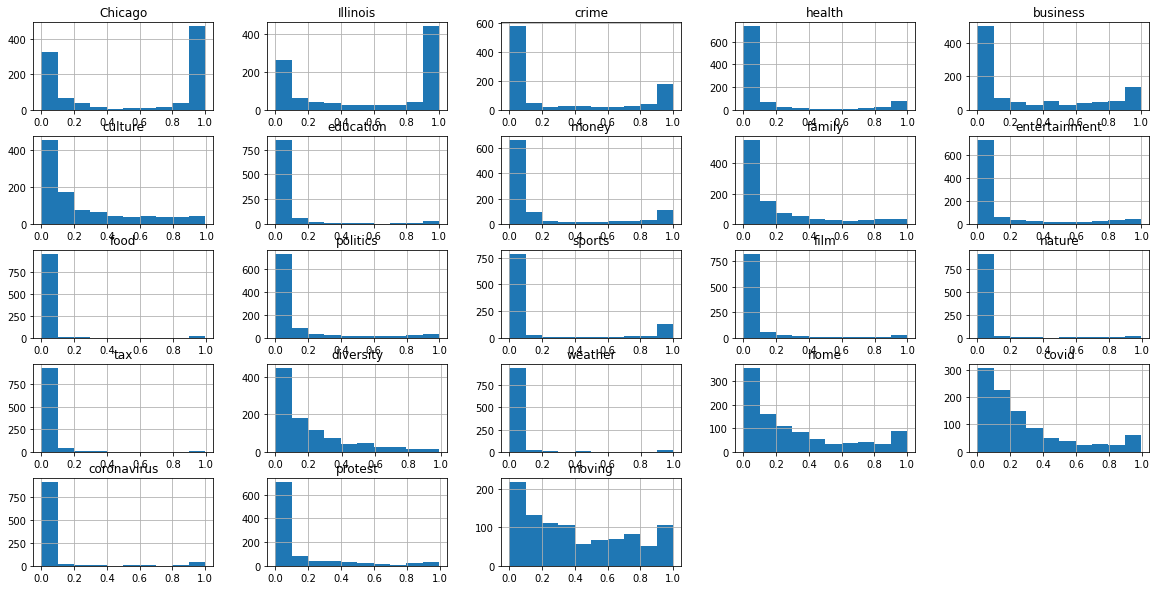

In [ ]:
# Visualize distribution for title column. Note for the most part, similar trends but lower incidence rates as most topics approach 1
title_results.hist(figsize = (20,10));

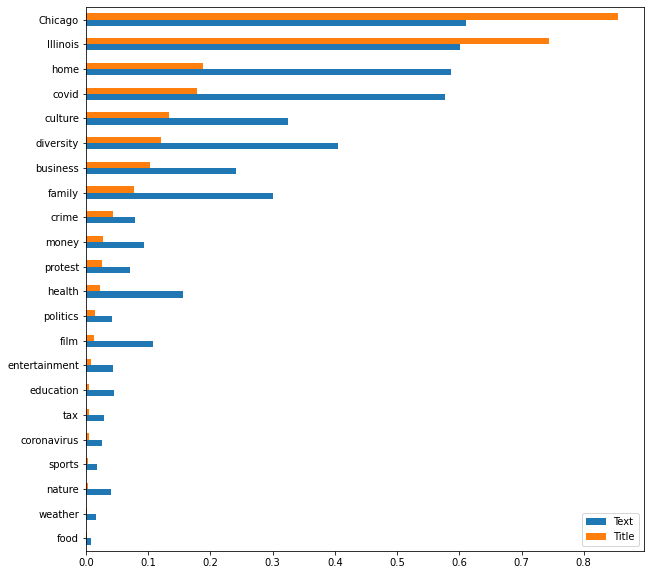

In [ ]:
# Visualize median value. Again, result shows higher classificaiton rate for text column. 
med_res = pd.DataFrame(text_results.median(axis=0)).rename(columns = {0:'Text'})
med_res['Title'] = title_results.median(axis=0)
med_res.sort_values(by='Title', ascending=True).plot.barh(figsize=(10,10))

In [ ]:
# Add original text/title to dataframe 
text_results.index = small_sample.index
text_results = text_results.join(small_sample['text'], how='inner')
text_results.head(5)

Chicago  ...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       text
9104    0.709733  ...  21 killed. Apparently two more died last night.I no longer GAF.L 14 posted on 06012020 7:07:07 AM PDT by Lurker Peaceful coexistence with the Left is not possible. Stop pretending that it is.  Post Reply  Private Reply  To 1  View Replies  To: PBRCat Soon well all be overwhelmed with political spin about whos at fault and why. As I write this, the progressive Democrats who run Chicago, Cook County and Illinois look shaken, and engage in virtue signaling at a news conference liberals mugged by reality.They simply didnt get the DNC talking points before they went on the air.But they will  and you can distill it down to three words: Orange M...
214325  0.228021  ...  Comment The Illinois football secondary will continue to improve as more talented players arrive in Champaign. Illinois was able to pull in a few players for the secondary from the class of 2021. Daniel Edwards was one of those players who committed to the Illini back on May 21. Edwards has now officially signed onto the Illinois program to be their future cornerback. Edwards is a 5foot11, 155pound cornerback from Winter Park Winter Park, Florida. , the No. 1017 88 cornerback 130 Florida. Breakdown of Edwards impact on IllinoisThe Illinois secondary is going to take a hit after the 2020 campaign. We are losing cornerback Nate Hobbs, who w...
242838  0.924326  ...  Chicago Capital LLC Raises Position in Alliance Data Systems Co. NYSE:ADS TweetChicago Capital LLC increased its stake in shares of Alliance Data Systems Co. NYSE:ADS by 245.1 during the fourth quarter, according to the company in its most recent disclosure with the Securities and Exchange Commission. The institutional investor owned 396,354 shares of the business services providers stock after buying an additional 281,493 shares during the period. Chicago Capital LLC owned about 0.83 of Alliance Data Systems worth 29,370,000 as of its most recent filing with the Securities and Exchange Commission.A number of other hedge funds also recent...
159057  0.973801  ...  Apr 30, 2020  2:59 PM Oprah Winfrey will give the address at CPSs virtual graduation ceremony.Emma McIntyreGetty Images None other than Oprah Winfrey has been named as the headliner at Chicago Public Schools virtual commencement ceremony for high school seniors, Mayor Lori Lightfoot announced Thursday afternoon.The times we are living in are historic and stunning, forcing us all to take a deep look at who we are as a people and our place in the world, Lightfoot said in a statement. No one knows this better than Oprah, and I join all of Chicago in looking forward to hearing the wisdom shell be sharing with our incredible young people as th...
244412  0.673337  ...  Jessica AlcazarToday we are celebrating the release of KIT by Brenda Rothert. This is a contemporary romance, and it is the eighth, standalone title in the Chicago Blaze hockey romance series. Join Brendas Reader Group for exclusive details about the series. Follow Brendas newsletter and join her Facebook group for exclusive details Kit by Brenda Rothert Available Now  Chicago Blaze , 8 Purchase KIT Here: Book Blurb: Kit Molly Lynch isnt like any woman Ive met before. The pretty, ballbusting reporter has a penchant for asking questions that dredge up memories Id rather keep buried. I answer them, though, because I

In [ ]:
# Add original text/title to dataframe. I was really happy with inspected classifications 
title_results.index = small_sample.index
title_results = title_results.join(small_sample[['title','text']], how='inner')
title_results.head(5)

Chicago  ...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       text
9104    0.994921  ...  21 killed. Apparently two more died last night.I no longer GAF.L 14 posted on 06012020 7:07:07 AM PDT by Lurker Peaceful coexistence with the Left is not possible. Stop pretending that it is.  Post Reply  Private Reply  To 1  View Replies  To: PBRCat Soon well all be overwhelmed with political spin about whos at fault and why. As I write this, the progressive Democrats who run Chicago, Cook County and Illinois look shaken, and engage in virtue signaling at a news conference liberals mugged by reality.They simply didnt get the DNC talking points before they went on the air.But they will  and you can distill it down to three words: Orange M...
214325  0.002679  ...  Comment The Illinois football secondary will continue to improve as more talented players arrive in Champaign. Illinois was able to pull in a few players for the secondary from the class of 2021. Daniel Edwards was one of those players who committed to the Illini back on May 21. Edwards has now officially signed onto the Illinois program to be their future cornerback. Edwards is a 5foot11, 155pound cornerback from Winter Park Winter Park, Florida. , the No. 1017 88 cornerback 130 Florida. Breakdown of Edwards impact on IllinoisThe Illinois secondary is going to take a hit after the 2020 campaign. We are losing cornerback Nate Hobbs, who w...
242838  0.982679  ...  Chicago Capital LLC Raises Position in Alliance Data Systems Co. NYSE:ADS TweetChicago Capital LLC increased its stake in shares of Alliance Data Systems Co. NYSE:ADS by 245.1 during the fourth quarter, according to the company in its most recent disclosure with the Securities and Exchange Commission. The institutional investor owned 396,354 shares of the business services providers stock after buying an additional 281,493 shares during the period. Chicago Capital LLC owned about 0.83 of Alliance Data Systems worth 29,370,000 as of its most recent filing with the Securities and Exchange Commission.A number of other hedge funds also recent...
159057  0.936207  ...  Apr 30, 2020  2:59 PM Oprah Winfrey will give the address at CPSs virtual graduation ceremony.Emma McIntyreGetty Images None other than Oprah Winfrey has been named as the headliner at Chicago Public Schools virtual commencement ceremony for high school seniors, Mayor Lori Lightfoot announced Thursday afternoon.The times we are living in are historic and stunning, forcing us all to take a deep look at who we are as a people and our place in the world, Lightfoot said in a statement. No one knows this better than Oprah, and I join all of Chicago in looking forward to hearing the wisdom shell be sharing with our incredible young people as th...
244412  0.986466  ...  Jessica AlcazarToday we are celebrating the release of KIT by Brenda Rothert. This is a contemporary romance, and it is the eighth, standalone title in the Chicago Blaze hockey romance series. Join Brendas Reader Group for exclusive details about the series. Follow Brendas newsletter and join her Facebook group for exclusive details Kit by Brenda Rothert Available Now  Chicago Blaze , 8 Purchase KIT Here: Book Blurb: Kit Molly Lynch isnt like any woman Ive met before. The pretty, ballbusting reporter has a penchant for asking questions that dredge up memories Id rather keep buried. I answer them, though, because I

Knowing how prohibitive this approach would be for the text column, more analysis was done on the title.

In [ ]:
# Inspect results for highly valued political title columns
print(len(title_results[title_results['politics'] >= 0.8]))
title_results[title_results['politics'] >= 0.8][['politics','title','text']].sample(5)

57


politics  ...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       text
204088  0.978285  ...                                                                                                                                                                                                                                                                                                                                                  Amid growing restrictions over the global coronavirus outbreak, Joe Biden racked up primary wins over Bernie Sanders in Arizona, Florida and Illinois on Tuesday, making his delegate lead for the Democratic presidential nomination all but insurmountable before the partys scheduled convention in July.Read more... 
91958   0.935901  ...  QUINCY  State Sen. Jil Tracy RQuincy says the Governors plan to reopen Illinois is too little, too late, and could very well mean the closing of many small businesses in west central Illinois.The 47th District Senator says the Governors plans for a regional reopening of the states economy do not reflect the diverse nature of the state and how communities across Illinois have been affected differently by the COVID19 pandemic.Data from COVID19 hotspots like Chicago are being used to make decisions that affect our entire state. These decisions are being made by our Governor in Chicago with little legislative input so the onesizefitsall order...
287728  0.890434  ...  SuperstoreA selective critical checklist of notable Thursday TVSuperstore 87c, NBC: A storm front approaches Cloud 9 in Season 6 in the form of, you guessed it, covid. While Dina  Lauren Ash  and Glenn  Mark McKinney  preen with pride at the very thought of being considered essential heroes as customers scramble for everyday items like toilet paper, Amys  America Ferrera  move to California has been delayed by the crisis, forcing way too many Zoom conferences that leave boyfriend Jonah  Ben Feldman  worrying where he fits in amid all this change. As masks and socially distanced lines become the new normal, the vignettes find humor in a se...
255171  0.978124  ...  Feb 3, 2021  06:55 PM PST  Updated: Feb 3, 2021  06:55 PM PSTThe seven defendants in the Chicago Conspiracy Trial hold a press conference in Chicago on Feb. 28, 1970, after the 7th Circuit U.S. Court of Appeals granted their request for bail. Left to right, Lee Weiner, Rennie Davis, David Dellinger, Abbie Hoffman, Tom Hayden, behind Hoffman, Jerry Rubin and John Froiners. Dellinger holds his granddaughter, Michelle Burd. JLP  Associated PressRennie Davis, one of the Chicago Seven activists who was tried for organizing an antiVietnam War protest outside the 1968 Democratic National Convention in Chicago in which thousands clashed with poli...
155698  0.851273  ...  National Guard Moves Into Chicago to Quell Possible Election Unrest On 11.03.20 11:33 AM posted by Jake Dima Democratic Illinois Gov. J.B. Pritzker has mobilized the National Guard to Chicago in preparation for potential unrest in the days following the 2020 general election . Pritzker said hes putting the military personnel in state of readiness, as he claimed the election results for the state may not be available until Wednesday, or Thursday, or even Friday, according to the Chicago Tribune .The move to station the National Guard is reminiscent of an earlier decision by the city in September, which followed th

In [ ]:
# inspect tax results 
print(len(title_results[title_results['tax'] >= 0.8]))
title_results[title_results['tax'] >= 0.8][['tax','title','text']].sample(5)

12


tax  ...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       text
55367   0.991615  ...  Mayor Lori Lightfoot said Chicago is projected to have a 700 million shortfall in its budget as a result of COVID19. ift.tt2XOy1sg Asian markets were broadly higher on Monday as traders looked forward to the continuation of trade talks between Chinese and American officials in Washington this week. from MarketWatch.com  Top Stories  February 18, 2019 Polish Prime Minister Mateusz Morawiecki has cancelled a visit to Israel for a highlevel summit, a government spokesperson told AFP on Sunday, after uproar in Poland over reported comments by Israeli leader Benjamin Netanyahu about the Poles and the Holocaust. Netanyahu  who was initially quo...
188275  0.954415  ...                                                                                                                                                                                                                                                                                                                                        to Lima. Lima, Peru  Photo: Christian Cordova via Flickr May 19th  23rd, 2021 This is just ONE SAMPLE travel date, for more availability, please follow the Fare Availability and How to Search for Availability instructions below from October  early December or late January 2021  May 2021. 3 days in advance of departure ORD
198754  0.895972  ...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             on the I55 Stevenson Expressway just east of Kenzie, in Chicago on June 8, 2020 Antonio Perez  Chicago Tribunevia chicagotribune.comAugust 31, 2020 at 09:44AM
39212   0.989671  ...  Illinois state Treasurer Michael Frerichs confirmed what many believe would be a new possibility in Illinois if voters pass the progressive income tax amendment: taxing retirees.One thing a progressive tax would do is make clear you can have graduated rates when you are taxing retirement income, he said while speaking at an event hosted by the Des Plaines Chamber of Commerce. And, I think thats something thats worth discussion.According to the Daily Herald , Frerichs said he knows people who receive annual pensions over 100,000 but pay no state income taxes. He said under the flat tax there is no way to differentiate between retirees who ...
275156  0.932740  ...  Map: How All of Illinois Voted on a Graduated Income Tax December 22, 2020 Analysts offer insight into the failure of the socalled fair tax amendment. By Alexandra Arriaga Map by Pat Sier. See more here . Should Illinois residents who take in more income pay a higher tax rate At its core, that was the matter at the top of every Illinois voters ballot this November. With huge amounts of resources poured into campaigns both for and against, the measure did not acquire the 60 of votes it needed to succeed. With the final results certified this week, we asked some analysts to help us understand the voting patterns. Chicag

In [ ]:
# inspect money column
print(len(title_results[title_results['money'] >= 0.95]))
title_results[title_results['money'] >= 0.95][['money','title','text']].sample(10)

95


money  ...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       text
310137  0.977461  ...                                                                                                                                                                             Jose Lopez earned 99,300 working for the Illinois Department of Children and Family Services during 2019, ranking them 817th in total compensation.The top paid public employee working for the Illinois Department of Children and Family Services was Deborah Folga, with a total compensation of 238,600.The data was gathered by the Illinois Comptroller Office . The 100 highest paid Illinois public employees working for the Illinois Department of Children and Family Services Rank
354604  0.981332  ...                                                                                                                                            Pamela Hartmann was ranked in the 94th percentile among public employees in Illinois in terms of pay in 2019, according to data gathered by the Illinois Comptroller Office .The employee earned 114,500 working as a registered nurse for the Illinois Department of Human Services.The highestpaid Illinois public employee was Faiza Kareemi, with a total compensation earning 392,600 working as a physician specialist for the Illinois Department of Human Services. The 100 highest paid Illinois public employees Rank
36921   0.970525  ...                                                                                                                                                                                                                                                                                                                                                Jessica AguirreJacob earned 33,600 during 2019 working for the Illinois Department of Corrections as an office assistant, according to data provided by the Illinois Comptroller Office .The average salary as an office assistant was 46,080 in 2019. Top 100 highest paid office assistants in Illinois listed below Rank
173772  0.967415  ...  Governor Pritzker Says Illinois Bars, Restaurants Need Federal Help Posted on by Lindsay RomanoOctober 8, 2020  Bars and restaurants in Illinois continue to struggle with stateimposed restrictions to reduce the spread of Covid19. With colder weather approaching, outdoor seating will begin to dissipate. Governor Pritzker is standing firm on his stance that restaurants and bars are hotbeds for the virus, and need federal help. They are the ones that have been most impacted because the medical advice has been that we have to limit the capacity there more than in other places in order to limit the spread of the virus, Pritzker said.An update ...
7443    0.983641  ...                                                                 Julian Torres earned 76,900 during 2019 working for the Illinois State Police as a trooper first class. This was a one percent decrease from the previous year according to data provided by the Illinois Comptroller Office .Dwayne Jennings saw the largest decrease in pay working as a trooper first class for the Illinois State Police in 2019, earning 42,100 less than in 2018.It is unclear whether the pay differences mentioned in this story are the result of differences in total time worked or of pay rates. The 100 highest paid public employees classified as

In [ ]:
#inspect moving column, unhappy with results 
print(len(title_results[title_results['moving'] >= 0.9]))
title_results[title_results['moving'] >= 0.9][['moving','title','text']].sample(5)

104


moving  ...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       text
303056  0.915238  ...  email This site is part of an affiliate sales network and receives compensation for sending traffic to partner sites, such as CreditCards.com. This compensation may impact how and where links appear on this site. This site does not include all financial companies or all available financial offers.We strongly encourage our readers to refrain from nonessential travel these next few weeks. Due to COVID19 we will only feature fares that have availability for travel from January 2021 onward. We will continually assess if that needs to move to an even later date.A good sale for nonstop service tofrom Tampa.This is a regular economy fare with ad...
228449  0.996126  ...  A daily blog on architecture in Chicago, and other topics cultural, political and mineral. Click on the COMMENTS link under each post to join the discussion. Wednesday, October 10, 2012 Moving Marina City to North Michigan for Open House Chicago 2012 click images for larger view For competent photographers it would just be a bad shot. For me, its fun with reflections. The Chicago Architecture Foundation held a press conference this morning to herald this weekends Open House 2012 , the amazing event that opens up over 150 Chicago buildings and places many not usually accessible, to the public. One spectacular addition this year is the top ...
266967  0.991507  ...  ShareElevated Chicago hosted its virtual 2020 symposium on July 31st, marking the organizations third year as they continue to focus on equitable transit oriented development eTOD around CTA stations. While TOD is focused on land use that encourages housing and businesses around transit nodes, eTOD seeks to address more broadly address displacement and disinvestment around transit.La Shone Kelly, Garfield Park Community Councils housing specialist, spoke during the symposium of the importance of eTOD in her community. Most of our residents are lowincome, so having affordable housing and healthcare thats easily accessible, being able to ge...
96057   0.954882  ...  Do you have any questions about Sherwood Lake Name Email Message Marco Amidei is an IL licensed real estate broker with REMAX Suburban. The data relating to real estate for sale on this website comes in part from the Broker Reciprocity program of Midwest Real Estate Data LLC. Real Estate listings held by brokerage firms other than MRED SmartFrame IDX Demo are marked with the MRED Broker Reciprocity logo or the Broker Reciprocity thumbnail logo the MRED logo and detailed information about them includes the names of the listing brokers. Some properties which appear for sale on this website may subsequently have sold and may no longer be ava...
314390  0.926190  ...  4726 N BRADY STREET, Davenport, IA 52806 5634243499 4726 N Brady St., Davenport, IA 52806 5632773224 ThePlatinumTeamQC.com What is your home worth Call for a FREE Market Analysis. 5632773224 M :30p M1 :00p 2 1 n Ope pM 1:00 0pM 0 : 2 n1 Ope 389,900 5526 Century Heights Av Mike Ingleby  Rebecca Hunter  Nate Lunsford pM 2:30 0pM 3 : 1 n Ope Bettendorf, IA Mike Ingleby pM 3:30 0pM 0 : 2 n Ope 519,900 5182 Pandit Drive Bettendorf, IA Mike Ingleby pM 2:30 0pM 0 : 1 n Ope 169,900 3692 8th St Ct. East Moline, IL Rebecca Hunter 1316 17th St Bettendorf, IA Rebecca Hunter 3877 Cobblestone Dr Bettendorf, IA Rebecca Hunter nt 

In [ ]:
# inspect
enviro_res = title_results[(title_results['weather']>=.8)|(title_results['nature']>=.8)][['title','text']]
print(len(enviro_res))
enviro_res.sample(5)

51


title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       text
133636             Chicago Weather: Clear Skies Through Monday, Showers After                                                                                                                                                                                     CHICAGO CBS  Clear skies will last through early Monday, but then, clouds and showers return for several days.On Sunday night, it will be clear with patchy frost and a low of 39.Credit: CBS 2On Monday, look for morning sun, then increasing clouds. There will be showers in the evening.The high for Monday is 64.Credit: CBS 2Temperatures will stay in the 60s and 70s for the entire sevenday forecast. Unfortunately, showers will linger form late Monday through Wednesday.
284442               King Kat Tournament Trail Cancelled at Grafton, Illinois  Wednesday, August 12, 2020 King Kat Tournament Trail Cancelled at Grafton, IllinoisLouisville, KY  The King Kat tournament scheduled for the Mississippi and Illinois Rivers at Grafton, IL has been cancelled for 2020 due to the COVID 19 virus.The Classic ChampionshipThis years Cabelas King Kat Classic Championship is scheduled for October 30  31, 2020 on Milford Lake in Milford, KS. The Classic features a guaranteed payout of 120,000 in cash and prizes. The points race is set to payout 30,000 to the top 20 places based on competitors the topfive finishes.For more information on the championship, other King Kat activities, and schedule upda...
79897                                 Chicago Weather: Warm And Sunny Weekend  Share 0CHICAGO CBS  Record breaking or near record breaking November weather should continue through Tuesday with highs of 70 or warmer, before a return to cooler weather midweek.Saturdays temperature has reached 71 this afternoon, a few degrees shy of the November 17 record 75 from 1915. Tonight will be clear and cool, with lows in the lower 50s. Credit: CBSSunday will be partly to mostly sunny again, with breezy and mild conditions, and a high in the mid 70s. The record high for November 8 is 73. Credit: CBSMild conditions continue on Monday and Tuesday, when highs will be in the 70s again. Tuesday also brings the next chance for rain, ...
368554  WTER 420 with CNW  Illinois Marijuana Sales Still Surging, Data Shows  WTER 420 with CNW  Illinois Marijuana Sales Still Surging, Data Shows October 12, 2020Months into the coronavirus pandemic, the statelegal cannabis industry is still going strong. Although the pandemic forced many industries to shut down, resulting in the loss of millions of jobs, the cannabis industry has fared quite well despite the economic crisis. Most states have seen increased cannabis sales month over month, with some even calling the industry recessionproof.One such state is Illinois, which has seen recordbreaking marijuana sales for the fifth time in a row. In September, consumers purchased more than 1.4 million marijuana product...
7873       As A Bear Roams In Illinois, Wildlife Officials Want It Left Alone  A black bear has been spotted several times this month in western Illinois. And authorities are telling the public to avoid getting too close or agitating the animal.Its unusual for a bear to show up in Illinois, although it happens from time to time. They usually come from the north, like this one that was seen near the Wisconsin border on June 

In [ ]:
# inspect
health_res = title_results[(title_results['health']>=.8)|(title_results['covid']>=.8)|(title_results['coronavirus']>=.8)][['title','text']]
print(len(health_res))
health_res.sample(5)

170


title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       text
313577                                                       CBS Chicago: Two Chatham restaurants could close due to pandemic  VIDEO This report features the owners of two Chatham restaurants both located on 75th Street. Mabes Deli and 5 Loaves  Ive yet to visit them and I hear a lot about their chicken  who are struggling thanks to this pandemic. Dinein is difficult because of mitigation efforts that either prohibited dinein service or limits the capacity of dinein service. Indeed the talk before the weather got colder was to allow tents to allow people to dinein, however, theyd do so outside of the establishment. Either way this pandemic has been painful for small businesses across the nation for sure. No comments: Post a Comment PLEASE READ FIRST Comment Moder...
201710  Diana Hill earns three percent more during 2019 working for the Illinois Department of Healthcare and Family Services                               Dec 1, 2020Diana Hill earned 74,700 during 2019 working for the Illinois Department of Healthcare and Family Services. This was a three percent increase over the previous year according to data provided by the Illinois Comptroller Office .Lisa Olivero saw the largest increase in pay working for the Illinois Department of Healthcare and Family Services in 2019, earning 68,800 more than in 2018.It is unclear whether the pay differences mentioned in this story are the result of differences in total time worked or of pay rates. Top 100 highest earners for the Illinois Department of Healthcare and Family Services Rank
336638                              Editorial: CPS and the coronavirus shutdown: Dont settle for a lost school year, Chicago   Chicago Tribune  Mar 30, 2020  5:00 AM Traffic passes Vaughn Occupational High School on March 6, 2020, in Chicago. The school was closed after an aide at the school tested positive for COVID19 early in the U.S. coronavirus outbreak.John J. Kim  Chicago Tribune With a school year interrupted by an 11day teachers strike last fall, and now on pause for at least a month due to the coronavirus pandemic, kids attending Chicago Public Schools are nearing an unfortunate benchmark: a lost school year.How to compensate Students deserve to have days made up at the end of the year, and that means preparing for the possibility now. If the Chicago Tea...
187903        Our Chicago: Voices of the Community town hall on blood donations during COVID pandemic hosted by Hosea Sanders  Our Chicago: Voices of the Community town hall on blood donations during COVID pandemic hosted by Hosea Sanders WLS By ABC 7 Chicago Digital Team Share: Share: CHICAGO WLS  ABC 7, Chicagos Number One station for news, will present the first virtual town hall installment in the new year, OUR CHICAGO: Voices of the Community. ABC 7s Hosea Sanders, who has been an important voice in ABC 7s annual Great Chicago Blood Drive, now in its 7th year, will moderate this hourlong event available on abc7chicago.com, Thursday, January 7, 2021 at 2:00 p.m.The need for blood donations has never been more urgent, yet with the pandemic, those donations hav...
285760                            Review: Virus could close Illinois community health centers  The Edwardsville Intelligencer  Close Image 1 of 12 Heather Burton, president and CEO of Central Counties Health Centers, in Springfield, Il

In [ ]:
# inspect 
culture_res = title_results[(title_results['culture']>=.95)|(title_results['entertainment']>=.95)|(title_results['food']>=.95)][['title','text']]
print(len(culture_res))
culture_res.sample(5)

59


title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       text
265598                              Your StaytheFHome Chicago Curated Weekend: 211 and Beyond  The Hideout Online @ Hideouts current streaming Home: NoonChorus , on your favorite streaming device, usually in the evening WHAT : Miss the good times spent at the Hideout Well heres the digital version SO WHAT: While we may not be able to properly hang at the Hideout just yet, we can still experience all the dancing, bingo, talk shows, music, comedy, and Robbie Fulks we can handle from home You just jump on over to the brand new Hideout Online at NoonChorus to join in on the Hideout digital community. They are offering a monthly subscription to watch their amazing lineup of shows for only for 25 You can still check out individual shows ...
338557                            Colby Museum of Arts new director is veteran Chicago artist  Colby Museum of Arts new director is veteran Chicago artist by Posted Jul 13, 2020 3:42 pm EDT Last Updated Jul 13, 2020 at 3:46 pm EDTWATERVILLE, Maine  A board member at the Art Institute of Chicago will be the new director of the Colby College Museum of Art, college officials said Monday.Jacqueline Terrassa will come to the position after serving as the womens board vicepresident for learning and public engagement at the Chicago institution, Colby officials said. She will step into her role at Colby in October.Colby president David Greene described Terrassa as an artist and educator who has helped transform the way museums engage with ...
156620                                                                           Chicago City                                                                                                                                                                                                                                                                                                                                                                                                                       Stayed here in early March... close to Michigan Ave... walking distance. Near shopping, restaurants, offices... clean, typical suite set up for Embassy Suites. Drinkssnacks in early evening and made to order hot breakfast Good deal, great price
156805                              Chicago: Win Passes To An Advance Screening Of The Banker  The bigger the dream, the higher the price. The Apple Original Film TheBanker comes to theaters on Dec 6.Based on a true story, The Banker centers on revolutionary businessmen Bernard Garrett Anthony Mackie and Joe Morris Samuel L. Jackson, who devise an audacious and risky plan to take on the racially oppressive establishment of the 1960s by helping other African Americans pursue the American dream. Along with Garretts wife Eunice Nia Long, they train a working class white man, Matt Steiner Nicholas Hoult, to pose as the rich and privileged face of their burgeoning real estate and banking empire  while Garrett and Morris pose as a janito...
300529  Cook carries Missouri St. over Loyola of Chicago 7462  The Edwardsville Intelligencer  Cook carries Missouri St. over Loyola of Chicago 7462 Updated 5:20 pm CST, Saturday, February 22, 2020SPRINGFIELD, Mo. AP  Keandre Cook had 21 points as Missouri State defeated Loyola of Chicago 7462 on Saturday.Gaige Prim had 16 points, nine rebounds and three blocks

##### NetworkX Visualization

I used NetworkX to try and understand relationship of these themes to one another. I found the results to be unhelpful. 

In [ ]:
# import packages 
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx

In [ ]:
# calculate cosine similarity 
cos_sim_sample = cosine_similarity(title_predictions)
cos_sim_sample = np.matrix(cos_sim_sample)

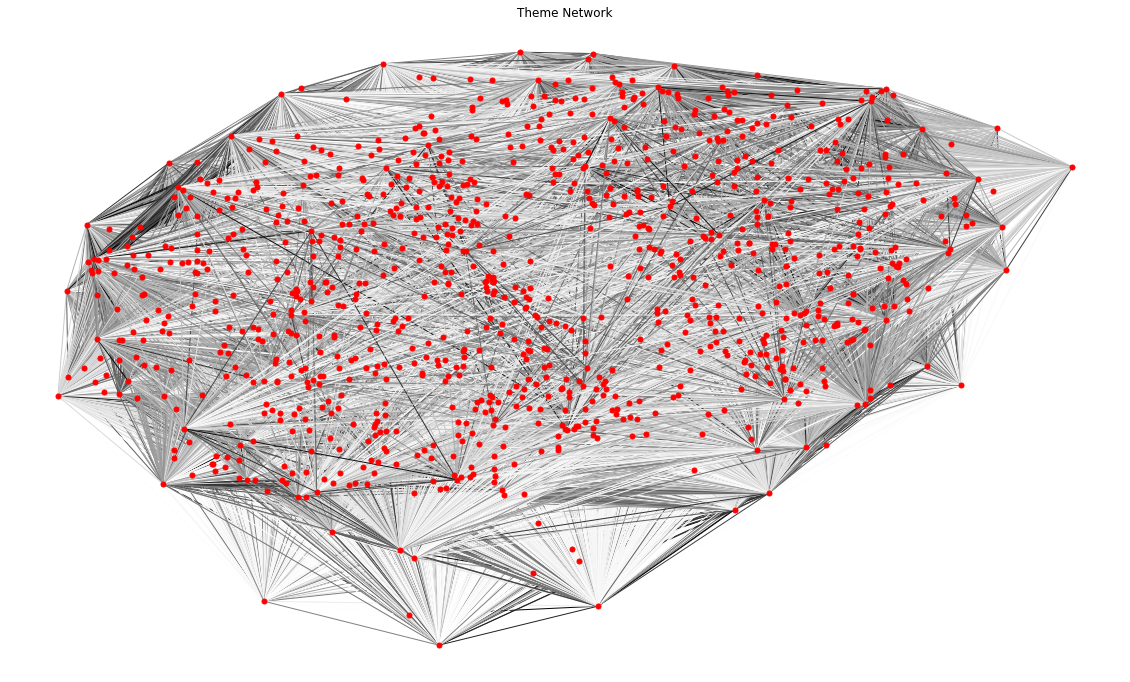

In [ ]:
# visualize, using cosine similarity as edge weight 
G = nx.from_numpy_matrix(cos_sim_sample)
G.remove_edges_from(nx.selfloop_edges(G))
figure(figsize=(20, 12))
plt.title('Theme Network')
nx.draw(G,edge_color = [ i[2]['weight'] for i in G.edges(data=True) ], edge_cmap=cm.Greys ,node_size=25, node_color='red')

##### DBSCAN

I also used DBSCAN to try and understand the clustering of these topics, but found they mostly clustered into two categories, which is unhelpful. 

In [ ]:
# import
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

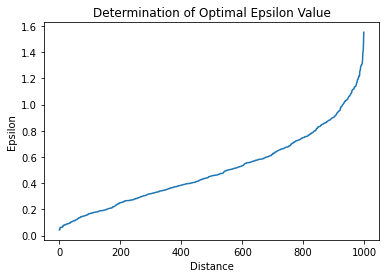

In [ ]:
# create nearest neighbour function to determine epsilon value 
def nearest_neighbour(df):
    neigh = NearestNeighbors(n_neighbors=2)
    nbrs = neigh.fit(df)
    distances, indices = nbrs.kneighbors(df)
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    plt.plot(distances)
    plt.title('Determination of Optimal Epsilon Value') 
    plt.xlabel('Distance')
    plt.ylabel('Epsilon') 

nearest_neighbour(title_predictions)

In [ ]:
# fit with epsilon = 0.9
db = DBSCAN(eps=.9, metric='euclidean', min_samples=10)
db.fit(title_predictions)
db_cluster = np.unique(db.labels_)
db_cluster=db.labels_

In [ ]:
# show number and count of labels. Not one major cluster and another set of outliers
np.unique(db_cluster, return_counts=True)

(array([-1,  0,  1]), array([204, 782,  14]))

### Exploratory Data Analysis - Snorkel

I tried to use Snorkel to overcome the computational challenges I found with Zero Shot Learning. However, I found a relatively low rate of classification due to the aforementioned overlap between themes. 

In [ ]:
# read in data 
df = pd.read_csv('/content/drive/My Drive/NLP_final_cleandf.csv', index_col=0)
small_sample = pd.read_csv('/content/drive/My Drive/NLP_final_sample_1000.csv', index_col=0)

#### Overarching Functions

In [ ]:
# Define categories based on previous analysis 

ABSTAIN = -1
Crime = 0
Sports = 1
Politics = 2
Business = 3
Covid = 4
Education = 5
Culture = 6

In [ ]:
# Defined functions based on important words/entities 
@labeling_function()
def police(x):
    return Crime if re.search(r"police|shoot*|crime|criminal|defendant|sheriff|gun", x.text, flags=re.I) else ABSTAIN

@labeling_function()
def sports(x):
    return Sports if re.search(r"Cubs|Bears|Bulls|NBA|NFL|Sox|hockey|football|basketball|athlete", x.text, flags=re.I) else ABSTAIN

@labeling_function()
def politics(x):
    return Politics if re.search(r"Pritzker|Trump|Biden|Lightfoot|Democrat*|Republican|Senate|House|bill|mayor|election|candidate|tax", x.text, flags=re.I) else ABSTAIN

@labeling_function()
def business(x):
    return Business if re.search(r"company|share|stock|quarter|business", x.text, flags=re.I) else ABSTAIN

@labeling_function()
def covid(x):
    return Covid if re.search(r"covid*|coronavirus|CDC|virus", x.text, flags=re.I) else ABSTAIN

@labeling_function()
def education(x):
    return Education if re.search(r"teacher|student|school|college|university", x.text, flags=re.I) else ABSTAIN

In [ ]:
# train model 
lfs = ([police, sports, politics, business, covid, education])

applier = PandasLFApplier(lfs)
%time L_train = applier.apply(small_sample)



  0%|          | 0/1000 [00:00<?, ?it/s]

  8%|▊         | 84/1000 [00:00<00:01, 829.41it/s]

 17%|█▋        | 167/1000 [00:00<00:01, 828.75it/s]

 23%|██▎       | 227/1000 [00:00<00:01, 743.24it/s]

 31%|███       | 308/1000 [00:00<00:00, 759.81it/s]

 37%|███▋      | 366/1000 [00:00<00:00, 671.30it/s]

 43%|████▎     | 428/1000 [00:00<00:00, 653.90it/s]

 51%|█████     | 506/1000 [00:00<00:00, 683.93it/s]

 58%|█████▊    | 579/1000 [00:00<00:00, 692.96it/s]

 64%|██████▍   | 645/1000 [00:00<00:00, 653.22it/s]

 72%|███████▏  | 722/1000 [00:01<00:00, 684.25it/s]

 79%|███████▉  | 790/1000 [00:01<00:00, 682.03it/s]

 88%|████████▊ | 877/1000 [00:01<00:00, 728.32it/s]

100%|██████████| 1000/1000 [00:01<00:00, 706.04it/s]

CPU times: user 1.4 s, sys: 8.26 ms, total: 1.41 s
Wall time: 1.43 s


In [ ]:
# show summary. Note all overlap or conflcit 
LFAnalysis(L=L_train[:10], lfs=lfs).lf_summary()

j Polarity  Coverage  Overlaps  Conflicts
police     0      [0]       0.2       0.2        0.2
sports     1      [1]       0.2       0.0        0.0
politics   2      [2]       0.6       0.6        0.6
business   3      [3]       0.4       0.3        0.3
covid      4      [4]       0.3       0.3        0.3
education  5      [5]       0.2       0.2        0.2

In [ ]:
# predict and show first few values 
label_model = LabelModel(cardinality=8, verbose=True)
label_model.fit(L_train=L_train, n_epochs=500, log_freq=100, seed=123)
snorkel_pred = label_model.predict(L=L_train)
snorkel_pred[:10]

array([ 2,  1,  2,  4,  1, -1,  2,  5,  2,  3])

In [ ]:
# Aggregate. Note fairly high volume of abstentions 
snorkel_sum = pd.DataFrame(np.unique(snorkel_pred, return_counts=True))
snorkel_sum.columns = ['ABSTAIN','Crime','Sports','Politics','Business','Covid','Education']
snorkel_sum

ABSTAIN  Crime  Sports  Politics  Business  Covid  Education
0       -1      0       1         2         3      4          5
1      260     62      72       301        79    126        100

In [ ]:
# preview results regarding COVID 
print(len(small_sample.iloc[L_train == Covid]))
small_sample.iloc[L_train == Business].sample(4, random_state=1)

255


crawled_date language  ... length article_len
197101  1593734400000  english  ...   1297          76
136902  1587427200000  english  ...   5226         193
96673   1588464000000  english  ...   3037          65
230224  1610496000000  english  ...   5691          98

[4 rows x 6 columns]

#### Granular Functions

In [ ]:
# Crime functions

@labeling_function()
def police(x):
    return Crime if re.search(r"police|sheriff", x.text, flags=re.I) else ABSTAIN

@labeling_function()
def shot(x):
    return Crime if re.search(r"shot", x.text, flags=re.I) else ABSTAIN

@labeling_function()
def crime(x):
    return Crime if re.search(r"crime|criminal", x.text, flags=re.I) else ABSTAIN

@labeling_function()
def gun(x):
    return Crime if re.search(r"gun", x.text, flags=re.I) else ABSTAIN

In [ ]:
# Sports functions

@labeling_function()
def cubs(x):
    return Sports if re.search(r"cubs", x.text, flags=re.I) else ABSTAIN

@labeling_function()
def bears(x):
    return Sports if re.search(r"bears", x.text, flags=re.I) else ABSTAIN

@labeling_function()
def bulls(x):
    return Sports if re.search(r"bulls", x.text, flags=re.I) else ABSTAIN

@labeling_function()
def sox(x):
    return Sports if re.search(r"sox", x.text, flags=re.I) else ABSTAIN


In [ ]:
# Politics functions

@labeling_function()
def pritzker(x):
    return Politics if re.search(r"Pritzker", x.text, flags=re.I) else ABSTAIN

@labeling_function()
def trump(x):
    return Politics if re.search(r"Trump", x.text, flags=re.I) else ABSTAIN

@labeling_function()
def biden(x):
    return Politics if re.search(r"Biden", x.text, flags=re.I) else ABSTAIN

@labeling_function()
def democrat(x):
    return Politics if re.search(r"Democrat*", x.text, flags=re.I) else ABSTAIN

@labeling_function()
def republican(x):
    return Politics if re.search(r"Republican*", x.text, flags=re.I) else ABSTAIN

@labeling_function()
def senate(x):
    return Politics if re.search(r"Senate", x.text, flags=re.I) else ABSTAIN

@labeling_function()
def congress(x):
    return Politics if re.search(r"Congress", x.text, flags=re.I) else ABSTAIN

@labeling_function()
def tax(x):
    return Politics if re.search(r"tax", x.text, flags=re.I) else ABSTAIN

In [ ]:
# Business functions

@labeling_function()
def business(x):
    return Business if re.search(r"business", x.text, flags=re.I) else ABSTAIN

@labeling_function()
def company(x):
    return Business if re.search(r"company", x.text, flags=re.I) else ABSTAIN

@labeling_function()
def share(x):
    return Business if re.search(r"share", x.text, flags=re.I) else ABSTAIN

@labeling_function()
def stock(x):
    return Business if re.search(r"stock", x.text, flags=re.I) else ABSTAIN


In [ ]:
# Covid functions

@labeling_function()
def covid(x):
    return Covid if re.search(r"covid", x.text, flags=re.I) else ABSTAIN

@labeling_function()
def coronavirus(x):
    return Covid if re.search(r"coronavirus", x.text, flags=re.I) else ABSTAIN

In [ ]:
# Education functions

@labeling_function()
def school(x):
    return Education if re.search(r"school", x.text, flags=re.I) else ABSTAIN

@labeling_function()
def college(x):
    return Education if re.search(r"college", x.text, flags=re.I) else ABSTAIN

@labeling_function()
def university(x):
    return Education if re.search(r"university", x.text, flags=re.I) else ABSTAIN

@labeling_function()
def teacher(x):
    return Education if re.search(r"teacher", x.text, flags=re.I) else ABSTAIN

@labeling_function()
def student(x):
    return Education if re.search(r"student", x.text, flags=re.I) else ABSTAIN

In [ ]:
# Culture functions

@labeling_function()
def restaurant(x):
    return Culture if re.search(r"restaurant", x.text, flags=re.I) else ABSTAIN

@labeling_function()
def bar(x):
    return Culture if re.search(r"bar", x.text, flags=re.I) else ABSTAIN

@labeling_function()
def food(x):
    return Culture if re.search(r"food", x.text, flags=re.I) else ABSTAIN

@labeling_function()
def music(x):
    return Culture if re.search(r"music", x.text, flags=re.I) else ABSTAIN

@labeling_function()
def film(x):
    return Culture if re.search(r"film", x.text, flags=re.I) else ABSTAIN

@labeling_function()
def comedy(x):
    return Culture if re.search(r"comedy", x.text, flags=re.I) else ABSTAIN

In [ ]:
#fit 
lfs = ([police, shot, crime, gun, 
cubs, bears, bulls, sox, 
pritzker, trump, biden, democrat, republican, senate, congress, tax,
business, company, share, stock, 
covid, coronavirus,
school, college, university, teacher, student, 
restaurant, bar, food, music, film, comedy])

applier = PandasLFApplier(lfs)
%time L_train = applier.apply(small_sample)



  0%|          | 0/1000 [00:00<?, ?it/s]

  7%|▋         | 72/1000 [00:00<00:01, 716.20it/s]

 14%|█▍        | 142/1000 [00:00<00:01, 711.23it/s]

 21%|██        | 209/1000 [00:00<00:01, 695.06it/s]

 26%|██▋       | 264/1000 [00:00<00:01, 644.03it/s]

 32%|███▏      | 322/1000 [00:00<00:01, 622.75it/s]

 38%|███▊      | 382/1000 [00:00<00:01, 611.71it/s]

 45%|████▍     | 446/1000 [00:00<00:00, 617.28it/s]

 51%|█████     | 511/1000 [00:00<00:00, 625.41it/s]

 58%|█████▊    | 579/1000 [00:00<00:00, 634.81it/s]

 64%|██████▍   | 640/1000 [00:01<00:00, 595.91it/s]

 70%|███████   | 704/1000 [00:01<00:00, 604.18it/s]

 76%|███████▋  | 764/1000 [00:01<00:00, 559.92it/s]

 83%|████████▎ | 831/1000 [00:01<00:00, 588.86it/s]

 90%|████████▉ | 899/1000 [00:01<00:00, 611.82it/s]

100%|██████████| 1000/1000 [00:01<00:00, 610.37it/s]

CPU times: user 1.61 s, sys: 8.91 ms, total: 1.62 s
Wall time: 1.65 s


In [ ]:
# Note poor coverage and high conflicts 
LFAnalysis(L=L_train[:10], lfs=lfs).lf_summary()

j Polarity  Coverage  Overlaps  Conflicts
police        0      [0]       0.1       0.1        0.1
shot          1       []       0.0       0.0        0.0
crime         2      [0]       0.2       0.2        0.2
gun           3      [0]       0.2       0.2        0.2
cubs          4       []       0.0       0.0        0.0
bears         5       []       0.0       0.0        0.0
bulls         6       []       0.0       0.0        0.0
sox           7       []       0.0       0.0        0.0
pritzker      8      [2]       0.1       0.1        0.1
trump         9       []       0.0       0.0        0.0
biden        10       []       0.0       0.0        0.0
democrat     11      [2]       0.1       0.1        0.1
republican   12      [2]       0.1       0.1        0.1
senate       13       []       0.0       0.0        0.0
congress     14       []       0.0       0.0        0.0
tax          15      [2]       0.1       0.1        0.1
business     16      [3]       0.2       0.2        0.1
company      17      [3]       0.3       0.3        0.2
share        18      [3]       0.1       0.1        0.0
stock        19      [3]       0.1       0.1        0.0
covid        20      [4]       0.3       0.3        0.3
coronavirus  21      [4]       0.1       0.1        0.1
school       22      [5]       0.1       0.1        0.1
college      23      [5]       0.1       0.0        0.0
university   24       []       0.0       0.0        0.0
teacher      25       []       0.0       0.0        0.0
student      26       []       0.0       0.0        0.0
restaurant   27       []       0.0       0.0        0.0
bar          28      [6]       0.1       0.0        0.0
food         29       []       0.0       0.0        0.0
music        30       []       0.0       0.0        0.0
film         31      [6]       0.1       0.1        0.1
comedy       32       []       0.0       0.0        0.0

In [ ]:
# predict, show first 10 results 
label_model = LabelModel(cardinality=8, verbose=True)
label_model.fit(L_train=L_train, n_epochs=500, log_freq=100, seed=123)
snorkel_pred = label_model.predict(L=L_train)
snorkel_pred[:10]

array([ 0, -1,  3,  4, -1,  6,  3,  5,  0,  6])

In [ ]:
# Aggregate results. Based on Zero Shot Learning, I wasn't comfortable with relatively low count for politics, sports and culture 
snorkel_sum = pd.DataFrame(np.unique(snorkel_pred, return_counts=True))
snorkel_sum.columns = ['ABSTAIN','Crime','Sports','Politics','Business','Covid','Education','Culture']
snorkel_sum

ABSTAIN  Crime  Sports  Politics  Business  Covid  Education  Culture
0       -1      0       1         2         3      4          5        6
1      274    145      39        37       171    207         82       45

In [ ]:
# preview, dissatisfied with results 
print(len(small_sample.iloc[L_train == Culture]))
small_sample.iloc[L_train == Culture].sample(4, random_state=1)

281


crawled_date language  ... length article_len
305680  1588896000000  english  ...   3734          57
371200  1597276800000  english  ...  10094          88
280245  1582588800000  english  ...   4718          76
135501  1595808000000  english  ...   3953          59

[4 rows x 6 columns]

### Full Data Topic Modeling using Zero Shot Learning 

After experimentation with different types of topic modeling, I determined that Zero Shot would best serve my beeds for this project. I first conducted analysis on 50,000 articles, and after seeing the computation speed, decided to ~ 100,000 more. I also needed to do some additional data cleaning at this point after noticing more irrelevant articles. 

In [ ]:
# read in data
df = pd.read_csv('/content/drive/My Drive/NLP_final_cleandf.csv', index_col=0)

In [ ]:
len(df)

220260

In [ ]:
# sample 50,000 rows 
big_sample = df.sample(n=50000, random_state=1)

In [ ]:
# define labels based on previous exploration 
zsl = ktrain.text.ZeroShotClassifier()
labels = ['crime',
          'health',
          'business',
          'culture',
          'education', 
          'family', 
          'entertainment',
          'food',
          'politics',
          'sports', 
          'nature',
          'tax',
          'weather', 
          'home',
          'covid',
          'coronavirus'
          ]


In [ ]:
# send titles to lsit 
titl = big_sample['title'].tolist()

In [ ]:
# fit 
%time title_predictions = zsl.predict(titl, labels=labels, include_labels=False, batch_size=64)

CPU times: user 52min 51s, sys: 51min 32s, total: 1h 44min 23s
Wall time: 1h 43min 48s


In [ ]:
#send to df, label
title_results = pd.DataFrame(title_predictions)
title_results.columns = labels

In [ ]:
# save 
title_results.to_csv('NLI_title_sample50000.csv')
!cp NLI_title_sample50000.csv "/content/drive/My Drive/"

In [ ]:
# read in data 
title_results = pd.read_csv('/content/drive/My Drive/NLI_title_sample50000.csv', index_col=0)

In [ ]:
# preview
title_results.head()

crime    health  business  ...      home     covid  coronavirus
0  0.989394  0.007334  0.308413  ...  0.027994  0.086866     0.004843
1  0.385085  0.069441  0.089446  ...  0.985394  0.136151     0.014775
2  0.826778  0.005143  0.084611  ...  0.120834  0.115048     0.001033
3  0.013574  0.093677  0.057885  ...  0.063112  0.160920     0.050686
4  0.014167  0.744845  0.007649  ...  0.044015  0.943871     0.987138

[5 rows x 16 columns]

In [ ]:
# add title and text columns 
title_results.index = big_sample.index
title_results = title_results.join(big_sample[['title','text']], how='inner')
title_results.head(5)

crime  ...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       text
205726  0.989394  ...                                                                                                                                     Saturday, February 13, 2021 In Creative Company and SAG interviews for The Trial of the Chicago 7 Some recent interviews promoting the movie. QA with actor Eddie Redmayne on The Trial of the Chicago 7. Moderated by Mara Webster, In Creative Company. x A QA with Eddie Redmayne of THE TRIAL OF THE CHICAGO 7. Moderated by Katey Rich, Vanity The movie was nominated for 3 SAG, 5 Golden Globe, 6 Critics Choice, and more awards won Movie of the year at AFI Awards. More nominations and awards to come in the coming weeks.
314588  0.385085  ...  Property Description Home FactsThis REO home included to this website from Mon, 23 Mar 2020 10:32:06 GMT. The property you seeing has COMING SOON status, so by now the owner is not taking the offers yet. COMING SOON status tells you that current property hasnt yet listed in MLS Multiple Listing Service system, on the other hand audience can already study it to view if this listing might be interesting for them and then add it to their watch list. Tip by IndexPost Property Location 401 N 19th St, Herrin, Illinois 62948 REO home positioned in Herrin, ZIP code 62948, in MCNEILLS H F 2ND ADD subdivision. Unfortunately IndexPost.com website do...
48810   0.826778  ...  admin Corruption , Democrats , Left Wing Extremists Leave a comment Like us on Facebook:Beetlejuice Lori Lightfoot stands with the left wing terrorist mob. After left wing terrorists tried to topple the Grant Park Columbus status, bue were eventually turned away by police, Lori Lightfoot did the job for them. She had the Columbus statue removed in the middle of the night while most people slept in Chicago. It was about this time last week when the left wing terrorists tried to remove the statue. Lori Lightfoot rewards terrorists. Beetlejuice Lightfoot removes Chicago Columbus statueDays after 19 Chicago police officers were hospitalized a...
194818  0.013574  ...  The Illinois Department of Natural Resources announced Monday that it would immediately close all state parks, fish and wildlife areas, recreational areas and historic sites.No date has been set for reopening the state parks, but the department said it would be working with Gov. J.B. Pritzkers office and the Illinois Department of Public Health to provide information as to the schedule for safely reopening our facilities, according to a news release Monday.All upcoming events at Illinois Department of Natural Resources sites were canceled.Those impacted by the cancellations and closures were asked to call the IDNRs Parks Administrative In...
163205  0.014167  ...  Mar 12, 2020  3:56 PM The Chicago Fires return to Soldier Field will have to wait a little longer.Major League Soccer on Thursday announced the suspension of play for 30 days because of concerns regarding the outbreak of the new coronavirus. The Fire were set to play Orlando City on the road Saturday before returning to Chicago for their March 21 home opener against Atlanta United. AdvertisementOur clubs were united today in the decision to temporarily suspend our season  based on the advice and guidance from the Centers for Disease Control and Prevention, Public Health Agency of Canada, and other public health auth

In [ ]:
# Took a second look at NER Data, and realized could omit more 'noise' 

title_results = title_results[~title_results['text'].str.contains('Illinois Tool Works')]
title_results = title_results[~title_results['text'].str.contains('Midwest Real Estate Data LLC')]
title_results = title_results[~title_results['text'].str.contains('MRED')]
title_results = title_results[~title_results['text'].str.contains('ITW')]
title_results = title_results[~title_results['text'].str.contains('Netflix')]
title_results = title_results[~title_results['text'].str.contains('Bancshares')]

In [ ]:
# resave
title_results.to_csv('NLI_title_sample47496.csv')
!cp NLI_title_sample47496.csv "/content/drive/My Drive/"

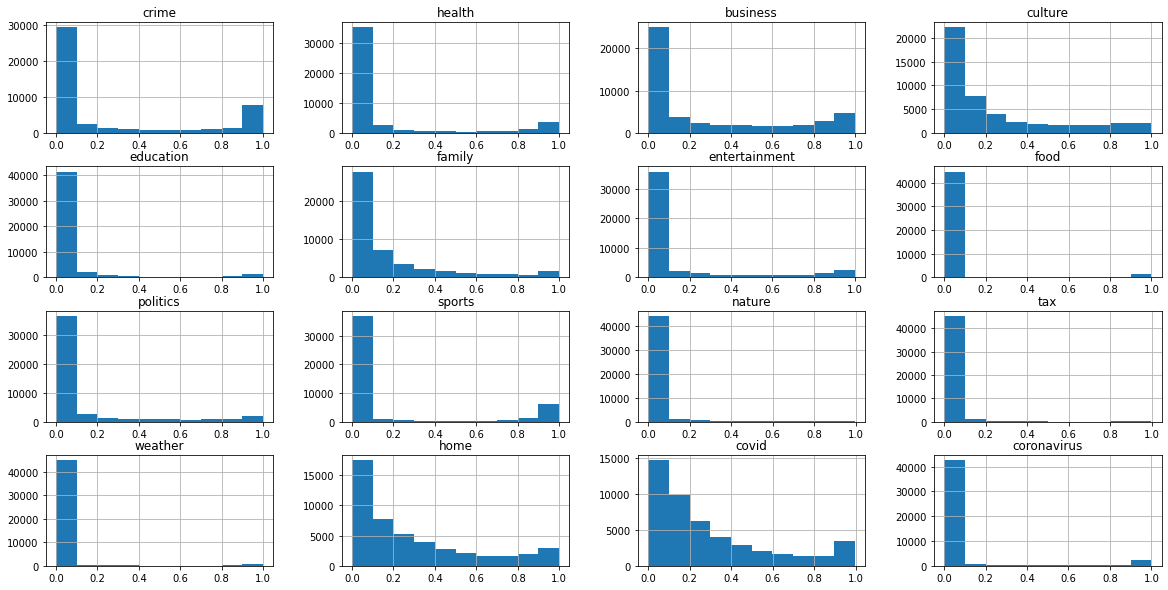

In [ ]:
# visualize 
title_results.hist(figsize=(20,10));

In [ ]:
# eliminated noise from full df 

df = df[~df['text'].str.contains('Illinois Tool Works')]
df = df[~df['text'].str.contains('Midwest Real Estate Data LLC')]
df = df[~df['text'].str.contains('MRED')]
df = df[~df['text'].str.contains('ITW')]
df = df[~df['text'].str.contains('Netflix')]
df = df[~df['text'].str.contains('Bancshares')]

In [ ]:
# save
df.to_csv('NLP_final_cleandf2.csv')

!cp NLP_final_cleandf2.csv "/content/drive/My Drive/"

In [ ]:
# read in 
title_results = pd.read_csv('/content/drive/My Drive/NLI_title_sample47496.csv', index_col=0)

In [ ]:
# drop previously sampled data
df2 = df.drop(list(title_results.index))

In [ ]:
# show new dataframe length 
len(df2) + len(title_results)

209503

In [ ]:
# create second sample so total = 150,000
big_sample2 = df2.sample(n=102504, random_state=1)

In [ ]:
# send title column to list 
titl = big_sample2['title'].tolist()

In [ ]:
# fit
%time title_predictions = zsl.predict(titl, labels=labels, include_labels=False, batch_size=64)

CPU times: user 1h 16min 48s, sys: 47min 56s, total: 2h 4min 44s
Wall time: 2h 3min 14s


In [ ]:
# create title dataframe
title_results2 = pd.DataFrame(title_predictions)
title_results2.columns = labels

In [ ]:
# save
title_results2.to_csv('NLI_title_sample102504.csv')
!cp NLI_title_sample102504.csv "/content/drive/My Drive/"

In [ ]:
# add title and text columns 
title_results2.index = big_sample2.index
title_results2 = title_results2.join(big_sample2[['title','text']], how='inner')
title_results2.head(5)

crime  ...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       text
285746  0.018447  ...  Mar 27, 2020 at 3:24am Getty Derrick Rose 25 of the Detroit Pistons.Derrick Rose was one of the best to ever put on a Chicago Bulls uniform.The Bulls first pick in the 2008 NBA Draft out of Memphis, Rose guided Chicago to some playoff appearances.His career in Chicago had up and downs after suffering multiple ACL and MCL injuries that changed the trajectory of his career.A native of Chicago and currently a member of the Detroit Pistons, Rose has career averages of 18.8 points, 3.4 rebounds and 5.6 assists per contest.Chicago is a competitive sports city and they love their Bulls.On a recent episode of the Scoop B Radio Podcast , I checked...
99377   0.001210  ...                                                                                                                                                                          Date: February 21, 2020 Author: Administrator 0 CommentsHomelessness in Chicago: Here are the statisticsThe Department of Family and Support Services conducted the last official homelessness survey for the city of Chicago in January 2019, by mandate of the Department of Housing and Urban Development HUD. It showed a slight drop in the overall number of homeless residents from 2018 and examined the demographic breakdown of those affected.via FOX NEWS Full Story Here Share this:
228833  0.993999  ...  13 1Missouri reached 16,962 cases on Tuesday. At least 896 people have died across the state during the outbreak.More than 300,000 people in Missouri have been tested for the virus.Many counties in our area are releasing zip code data.Illinois has seen many more cases than Missouri, reaching 133,818 on Tuesday. The majority of those patients are in the Chicago area.Illinois has seen 6,414 deaths from COVID19 since the outbreak began.More than 1,180,000 people in Illinois have been tested for the virus.The number of cases reported on the Illinois side of News 4s viewing area also continues to grow. Tracking coronavirus cases, deaths in Ill...
312103  0.890179  ...  Man Turns Himself In for Fatal HitandRun of Woman in Wheelchair: St. Charles PoliceTwo people arrested were evaluated for minor injuries, police said.Protesters have gathered every day since prosecutors announced Wednesday that they would not charge Officer Joseph Mensah in 17yearold Alvin Coles death. Mensah, who is Black, shot Cole after a foot chase outside a Wauwatosa mall in February.About an hour after Fridays curfew went into effect, law enforcement began advancing toward the crowd. Police said some protesters threw rocks and bottles at law enforcement, and police said they used chemical irritants, which they described as tear gas,...
369171  0.000229  ...  Histories Of The Classic Railroads Chicago  North Western F7s and a Fairbanks Morse unit lead a mixed freight train near Peoria, Illinois on June 8, 1956.These original prior to the megamerger movement which has granted some railroads direct access to Chicago such as Union Pacific and Canadian National classic carriers include the Atchison, Topeka  Santa Fe 1888 Railway Baltimore  Ohio Railroad 1874 Chicago  North Western Railway which has its beginnings in Chicago in 1848 Chicago, Burlington  Quincy Railroad which has its origins from the little Galena  Chicago Union Railroad in 1849 Milwaukee Road 1874 Rock Island

In [ ]:
# create one dataframe with all results 
final_nli = pd.concat([title_results, title_results2])
final_nli.sample(5)

crime  ...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       text
292822  0.000132  ...  Chicago Elementary School Assigned Students A Project About African Animals For Black History Month One parent said, Its ignorant and racially insensitive. Published 2 minutes ago Written by BET StaffParents are speaking out after their children were assigned a project about African animals for Black History Month. Three white kindergarten teachers at Sutherland Elementary, a neighborhood Chicago Public School rooted in Beverly, Illinois, thought of a bizarre Black History Month assignment and sent children home with a note that read, We are celebrating African American History Month in various ways at Sutherland this month. Since our stu...
159815  0.005076  ...  Health officials believe a Chicago man who was diagnosed with coronavirus is the first communitytransmitted case of the virus in the city.The resident, a man in his 60s, is currently hospitalized and is in serious condition, according to health officials.Officials say that the man has not traveled to any countries impacted by coronavirus, and that he has no connection to any other existing cases.The investigation is still ongoing, but based on what we know so far, this case has not been linked to any travel or to any COVID19 case, Dr. Allison Arwady, Director of the Chicago Department of Public Health, said.The mans case is the seventh di...
206233  0.025857  ...  Illinois State football opener against Missouri State postponed New 6:03 pm Holden Krusemark Top Sports Stories , Illinois State University SportsNORMAL HOI  After months of waiting in anticipation of finally starting their football season, the Illinois State Redbirds will now have to wait longer for kickoff. The Missouri Valley Football Conference announcing Wednesday the season opener between the Redbirds and Missouri State is being postponed until April 17, because of unsafe field conditionsMeaning Illinois State will now start the season Feb. 27 at home against South Dakota.ISU Head Coach Brock Spack wasnt pleased with the conferences...
309048  0.000722  ...  CHICAGO  A Chicagobased sporting goods business is reeling in customers because of the pandemic. They are so popular that even NBA players stuck in the Florida bubble are using their products to catch a break.Catch Co. is an online company that specializes in fishing gear. Itaposs the ultimate social distancing sport.In 2012, Founder and CEO Ross Gordon was looking for a Tackle of the Month Club but couldnapost find it. So, he started a business doing just that, right out of his Evanston garage.Weaposre able to pull so many young people into the sport by being relatable, being authentic, Gordon said.The companyaposs Mystery Tackle Box is ...
168613  0.002524  ...                                                                                                                                                                                                                          Wow brings TV service to Chicago, Evansville, Detroit Thursday 16 July 2020  16:30 CET  News Wow Internet, Cable  Phone said its TV IPTV service became available to its highspeed data customers in Chicago, Evansville and Detroit. Already available in its Columbus, Ohio, Cleveland and midMichigan markets, the Android TVbased platform features curated live channel packages, a cloud DVR, and access to an ex

In [ ]:
# save
final_nli.to_csv('NLI_FINAL.csv')
!cp NLI_FINAL.csv "/content/drive/My Drive/"

#### Variable definition

In [32]:
# read in data 
final_nli = pd.read_csv('/content/drive/My Drive/NLI_FINAL.csv', index_col=0)

In [33]:
# omit more irrelevant data 
final_nli = final_nli[~final_nli['text'].str.contains('chicago 7', flags=re.I)]
final_nli = final_nli[~final_nli['title'].str.contains('Department')]
final_nli = final_nli[~final_nli['title'].str.contains('roundtrip', flags=re.I)]

In [34]:
# new length 
len(final_nli)

144037

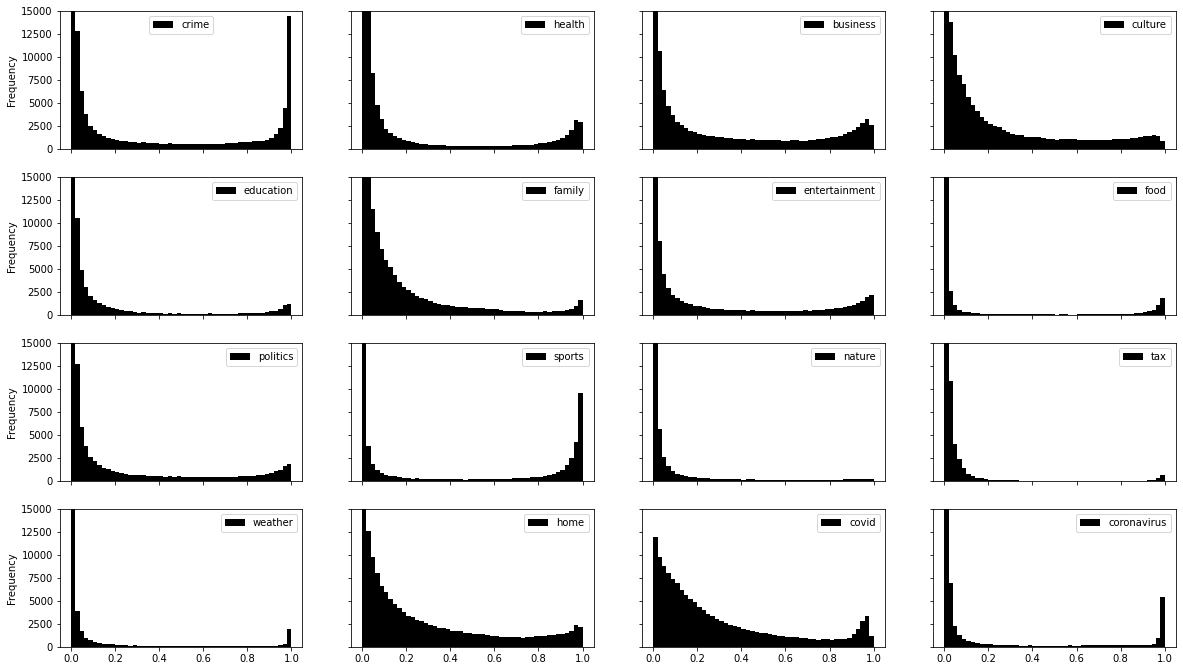

In [35]:
# visualize distribution 
final_nli.loc[:, :"coronavirus"].plot.hist(subplots=True, bins=50, figsize=(20,30), color='black', grid=False, sharey=True, ylim=(0,15000), layout=(10,4));

In [36]:
# describe. Note all variables achieved a high classifcation at some point 
final_nli.describe()

crime         health  ...          covid    coronavirus
count  144037.000000  144037.000000  ...  144037.000000  144037.000000
mean        0.276137       0.164089  ...       0.294225       0.080285
std         0.381092       0.301430  ...       0.284208       0.236940
min         0.000041       0.000045  ...       0.000088       0.000073
25%         0.005036       0.004433  ...       0.073832       0.001901
50%         0.033372       0.018822  ...       0.188917       0.004346
75%         0.568779       0.102937  ...       0.432569       0.012306
max         0.999698       0.999256  ...       0.998506       0.999835

[8 rows x 16 columns]

In [38]:
# explore crime articles 
crime_df = final_nli[final_nli['crime'] >= 0.8]
print(len(crime_df))
print(len(crime_df)/(len(final_nli)))
crime_df.sample(5)[['title','text']]

28618
0.1986850600887272


title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       text
315062                                                                          236 more COVID cases in Illinois, 0 in Knox County  GALESBURG  As the official count of confirmed coronavirus cases in Illinois increased another 236 Monday, the Knox County County Health Department is still not reporting any cases.The KCHD says 19 tests have been administered in Knox County, with no positive tests, 10 pending and nine negative tests as of Monday. This marks an increase in six tests from the numbers given Sunday, which stated there were 10 pending tests and three negative in Knox County.All in all, Illinois now has 1,285 confirmed cases in 31 counties, with Monroe County reporting its first case Monday. Three deaths were also reported in Cook County: two men in their 80s a...
335642  Suspect in custody, charges pending in killing of 7yearold girl shot while visiting grandmother in Chicago  News  Features  CHICAGO  One person was in police custody and charges were pending Monday in the killing of a 7yearold girl fatally shot July Fourth as she visited her grandmother in the South Austin neighborhood, authorities said.Natalia Wallace, who was due to start second grade at Crown Community Academy of Fine Arts, was shot just after 7 p.m. in 100 block of North Latrobe Avenue, according to authorities.A suspect in Natalias killing was in custody Monday morning and charges were pending, according to a police spokeswoman.After Natalias killing, the school released a statement, attributed to Natalias first grade teacher:Natalia was a very quiet and ...
152432                                                     Police Video of Fatal Shooting of Motorist in Illinois Will Be Released  Police Video of Fatal Shooting of Motorist in Illinois Will Be Released By Reuters , Wire Service Content Oct. 25, 2020 By Reuters , Wire Service Content Oct. 25, 2020, at 10:00 p.m. FILE PHOTO: A view outside the Lake County Courthouse is seen following the Kenosha, Wisconsin shooting of protesters, in Waukegan, Illinois, U.S. August 26, 2020. REUTERSStephen MaturenFile Photo ReutersBy Rich McKayReuters  The Waukegan, Illinois, police video of the shooting death of an unarmed Black teenaged motorist, who wanted to be a rapper, will be released to the public, the mayor said at a prayer vigil Sunday.The videos release will add a measure of...
251491                                                               Not known Factual Statements About chicago hard money lenders  Not known Factual Statements About chicago hard money lenders Renovo Financial222 W Adams St 3150, Chicago, IL 60606V9H8Q4 Chicago, Illinois, United StatesPh: 1 312 279 7305 Funding Economic will lend to expert operators with a flag while in the lodge and lodging sector.Several property investors use hard money loans simply because they can typically borrow approximately 100 of the purchase selling price There are a variety of how individuals confer with the financial loans that housing investors makeAll sorts of businesses are suitable, While remarkably specialized and startups will frequently not qualify. Principals will need superior c...
347564                                      BLACKHAWKS STATUE IN CHICAGO COATED IN PAINT AND VANDALISM CRITICISING POLICE, BIGOTRY  A statue of the Chicago Blackhawks celebrating the Native American leader named aft

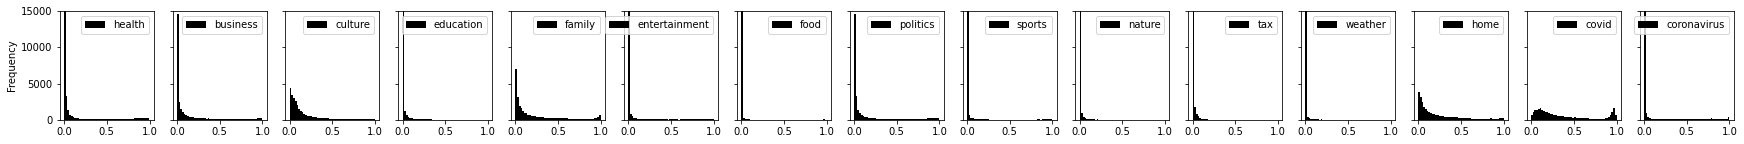

In [39]:
# look for overlap with other themes 
crime_df.loc[:, "health":"coronavirus"].plot.hist(subplots=True, 
                                           bins=50, 
                                           figsize=(30,2), 
                                           color='black', 
                                           grid=False, 
                                           sharey=True, 
                                           ylim=(0,15000), 
                                           layout=(1,15)
                                           );

In [41]:
# explore covid articles, aggregating results for both 'covid' and 'coronavirus'
covid_df = final_nli[(final_nli['covid'] >= 0.8)|(final_nli['coronavirus'] >= 0.8)]
print(len(covid_df))
print(len(covid_df)/(len(final_nli)))
covid_df.sample(5)[['title','text']]

19605
0.136110860403924


title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       text
135549                                          Illinois announces more than 1,200 new coronavirus cases  WIBQ  SPRINGFIELD WTWOWAWV  The Illinois Department of Public Health announced 1,231 new coronavirus cases from 30,567 tests Monday afternoon, as well as 18 more deaths from the illness.These new numbers bring the totals to 172,655 cases and 7,416 deaths from over 2.5 million tests throughout the state. Over 1,400 people are hospitalized due to the illness, with 350 of those patients in intensive care.The deaths were mostly concentrated in highlypopulated Cook County, and the victims in all but two cases were over the age of 50.Illinois is also reporting 1,242 probable cases and 192 probable deaths in keeping with guidelines from the CDC. On Ai...
285040                                                                              chicago hospital and covid                                                                                                                                                                                                                                                                                                                                                                                                       How was your labor experience with covid and allWas baby daddy allowed through entire process How long and did you wear a maskWas anything different from non covid labor experiencesFTM and want to know what to expect with covid and all. I get induced in 3 days
286163  Amid coronavirus fallout, Chicago will give 1,000 grants to help some residents with mortgage payments  The city of Chicago will give onetime 1,000 grants to help residents who have suffered financially due to the coronavirus outbreak with rent and mortgage payments, Mayor Lori Lightfoot announced.Lightfoot announced the COVID19 Housing Assistance Grant program on Friday, which she said will go toward Chicagoans who have lost their jobs or otherwise been impacted by the economic fallout from the COVID19 pandemic.Advertisement The city will spend 2 million from its Affordable Housing Opportunity Fund for the payments.This program represents a critical resource not only to our communities but our entire city as we navigate this evolving chall...
344587                                     Coronavirus In Illinois: 22,025 Confirmed COVID19 Cases, 794 Deaths  Coronavirus In Illinois: 22,025 Confirmed COVID19 Cases, 794 Deaths April 13, 2020 at 3:56 pm Filed Under: Chicago News , Coronavirus , COVID19 , JB Pritzker , Tracking Coronavirus In ChicagolandCHICAGO CBS  With 1,173 new cases of COVID19 in Illinois, including 74 additional deaths, Gov. JB Pritzker said its still not clear when his statewide stay at home order will be lifted.The order currently is set to expire on April 30, and Mayor Lori Lightfoot earlier in the day said she expected the governor would extend that order into May. Pritzker himself wouldnt speculate on exactly how much longer the order will remain in plcace.I cant tell y...
163516                           Work, play and home all affected by coronavirus fears across Central Illinois  BLOOMINGTON  A mix of prudence and concern about coronavirus swept through Central Illinois Thursday, closing universities and schools, changing work schedules at large employers, can

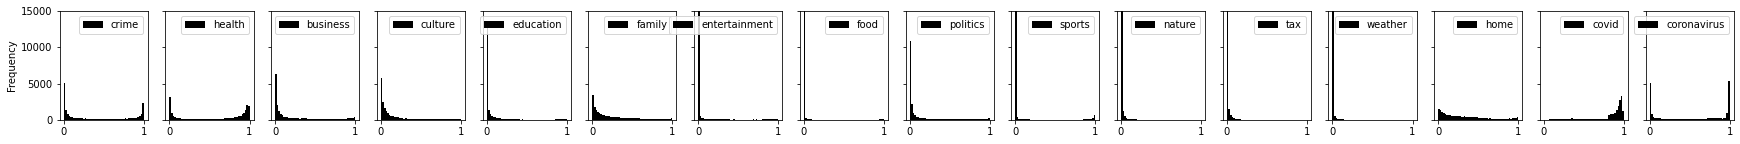

In [42]:
# visualize 
covid_df.loc[:, :"coronavirus"].plot.hist(subplots=True, 
                                           bins=50, 
                                           figsize=(30,2), 
                                           color='black', 
                                           grid=False, 
                                           sharey=True, 
                                           ylim=(0,15000), 
                                           layout=(1,16)
                                           );

In [43]:
# create leisure dataframe, aggregating highly loaded culture, entertainment or food topics 
leisure_df = final_nli[(final_nli['culture'] >= 0.8)|
                       (final_nli['entertainment'] >= 0.8)|
                       (final_nli['food'] >= 0.8)]
print(len(leisure_df))
print(len(leisure_df)/(len(final_nli)))
leisure_df.sample(10)[['title','text']]

22965
0.15943819990696834


title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       text
296941  Watch now: Reinhardt top games No. 5: Illinois State women thrill home crowd with WNIT win over Illini  SaveThe 2010 WNIT bracket was kind to the Illinois State womens basketball team.It was kind not in funneling weak opponents the Redbirds way, but instead offering challenging, confidencebuilding games to set up a March 28 encounter at Redbird Arena.ISU defeated Butler, 5754, traveled to Purdue to edge the Boilermakers, 5957, behind 21 Nicolle Lewis points and handled Kansas, 7151, at home sparked by 15 points and seven rebounds from Ashleen Bracey.Those three victories forged a dream matchup with the University of Illinois heading to Normal for a quarterfinal game. The Illini had toppled ISU, 6251, on Nov. 24, 2009, at Redbird Arena.With ...
70390     JeanMichel Basquiats 100M Boy and Dog in Johnnypump Going On Display at the Art Institute of Chicago  A vast amount t of artwork we see in museums belong to private collectors who share them with the world. Bless them, and especially philanthropist Kenneth C. Griffin who bought JeanMichel Basquiats enormous painting, Boy and Dog in Johnnypump for more than 100 million.He currently shares a large swath of his work with public museums, like Jackson Pollocks Number 17A, and Willem de Koonings Interchanged. Boy and Dog joins those, and will be on display at the Modern Wing of the Art Institute of Chicago when the museum reopens.Boy and Dog in Johnnnypump was created by Basquiat in 1982, a time when people say he was at the height of his caree...
82929                                 Chicago, You Come to My Senses from Twenty 1 1991: Saturdays in the Park  Chicago, You Come to My Senses from Twenty 1 1991: Saturdays in the Park Share this:Tom Kelly and Bill Steinberg knew how to write decent pop songs. Much of what they recorded as ITen on 1983s Taking a Cold Look , their one and only album, was later covered to great success by other bands and musicians.Kelly and Steinberg scored a hit with Madonnas Like a Virgin back in 1984, and they also wrote Hearts 1987 smash Alone. By the way, Like a Virgin was produced by Patrick Leonard, who went on to work with Peter Cetera on 1988s One More Story , but I digress. So, its no surprise that Alone producer Ron Nevison returned to the well for 1991s T...
39339                                                                PJ Soles at Days of the Dead Chicago 2014  Days of the Dead returns to Indianapolis July 1719. As always, it will be a weekend of horror and pop culture fun. Until then, I recall some of my fun times at previous events.I have been a longtime fan of PJ Soles. I loved her as Riff in Rock n Roll High School , but she has appeared in so many other classic movies, too. Carrie , Halloween , Stripes and Private Benjamin are just a few of her older movies. She was even in The Boy in the Plastic Bubble .PJ is not just one of my favorites, she is one of the best convention guests. Whether at her table or in the hallways, PJ is always ready with a smile or hug. She has a large supply of seve...
272944                                                 October is College Changes Everything month in Illinois   and families are encouraged to take full advantage of the free financial aid and postsecondary planning resources available in their communities as part of College Changes Everything

In [44]:
#xplore health, dissatisfied with results, mostly about covid 
final_nli[final_nli['health'] >= 0.8].sample(5)[['title','text']]

title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       text
225049                                                                            Chicago : FDA approves promising saliva test to detect COVID19  .  Home USA Chicago : FDA approves promising saliva test to detect COVID19  . Chicago : FDA approves promising saliva test to detect COVID19  . August 17, 2020WASHINGTON  The U.S. Food and Drug Administration FDA announced Saturday that it has urgently authorized a COVID19 test based on saliva samples and that has been tested for more than a month in gamers. basketball player.The test, developed by researchers at Yale University, has attracted the attention of many public health experts because, unlike other tests, it does not require a specific instrument to record the sample, but saliva can be stored in any sterile container and submitted ...
314964                                                        Man charged, accused of coughing in Chicago officers faces, saying he had coronavirus  Anthony Ponzi Man charged, accused of coughing in Chicago officers faces, saying he had coronavirus Anthony PonziCHICAGO  A 21yearold man is facing charges after prosecutors said he said he was infected with coronavirus and coughing into Chicago police officers faces Sunday, March 22 in Rogers Park on the citys north side.Anthony Ponzi was charged with two felony counts of aggravated battery to a peace officer and several misdemeanor charges, including battery DUI, and resisting arrest, Chicago police said.Officers responded to a call of a crash about 8 a.m. in the 7400 block of North Wolcott Avenue, police said, adding that Ponzi was dri...
115496  Got em.Illinois town mayor is shocked after sending cops to break up parties amid coronavirus lockdown only to find his WIFE at one of them  Illinois town mayor is shocked after sending cops to break up parties amid coronavirus lockdown only to find his WIFE at one of them Alton, Illinois, Mayor Brant Walker issued an apology on behalf of wife Shannon after she was caught at illegal gathering at Hirams Tavern Sunday Walker said he instructed the chief of police to treat his wife as he would any citizen violating the Stay At Home order Illinois Gov JB Pritzker issued executive order on March 20 prohibiting all social gatherings to help stop the spread of the coronavirus Walker said in a Facebook statement his wife is an adult capable of making her own decisions, and in this ins...
266250                                             Coronavirus Kills 284 Illinoisans Over Weekend, Bringing Death Toll To 13255  Block Club Chicago  At least 13,255 people have died from COVID19 in Illinois, and another 861 deaths are considered to be probably related to coronavirus. The state also reported 17,485 confirmed cases over the weekend. That brings the total number of confirmed cases in Illinois up to 787,573.It is devastating, its just devastating for the country, for the state of Illinois, for all of us who are very focused on trying to save peoples lives, Gov. JB Pritzker said Thursday. Some of those of the people who passed away, they probably went to the hospital at some point, then they became an ICU patient, some of them went on ventilators. I look at it and I say, H...
324807                         Coronavirus Illinois: IL reports 1,173 COVID19 cases, 6 deaths as state poised to receive millions in federal relief

In [45]:
# explore family topic, dissatisfied with relevancy for this project 
final_nli[final_nli['family'] >= 0.95].sample(5)[['title','text']]

title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       text
12881                                                             Only God Can Fix It Illinois Family Spotlight 219                                                                                        In case you havent noticed, life is hectic right now, especially in politics. Nearly every person is spinning theories about repairing our political system or gloating over the presidents illness, or how one party is the unique savior of the republic. Reverend Franklin Graham disagrees and instead posits that only Christ and Him crucified can repair human lives, thus the culture, and thus human politics.This episode is a reair of the interview IFIs media director, Monte Larrick, did with Reverend Graham directly before IFIs fall fundraising banquet in 2019.
59165                                                                                        Barconey Jr., Illinois  Illinois Barconey Jr. entered into eternal rest on Sunday June 21, 2020 at Chateau De Notre Dame Nursing Home at the age of 94. Son of the late Illinois Sr. and Malinda Barconey. Husband of the late Loretta Y. Barconey. Father of JoAnn Sparks, Joyce Barconey and Evelyn Henry and the late Illinois Barconey III, Gaynel B. Johnson, Oliver Lee Barconey and Detta B. Ladd. Brotherinlaw of Luteshia Roberts. Brother of the late Edward Barconey. Uncle of Loretha Woods, David Hicks, Paul Hicks and Mitchell Hicks. Also survived by 22 grandchildren, a host of greatgrandchildren, greatgreat grandchildren, other relatives and friends. Relatives and fri...
19475                                                     Chicago skyline, Gene and Jesses trip downtown around 194                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       Explore KuffelWesol Family Projects photos on Flickr. KuffelWesol Family Project has uploaded 1647 photos to Flickr.
4699                     Selena Gomez Bonds With Mom Mandy Teefey On Chicago Trip: See Rare Photos Of Them Together                                                                                                                                                                                                                                                                                                                                                                                                                                            Selena Gomez and her mom Mandy Teefey took a motherdaughter weekend trip to Chicago. The singer shared a series of pics where they took in the sights and also helped solve a reallife murder at CrimeCon. from Hollywood Life 
96188  Coronavirus deaths: Chicago family loses mother, son to COVID19 father finds out after coming off ventilator  Coronavirus deaths: Chicago family loses mother, son to COVID19 father finds out after coming off ventilator WLS Share: Share: CHICAGO WLS  A Chicago family h

In [46]:
# explore education variable 
education_df = final_nli[final_nli['education'] >= 0.8]
print(len(education_df))
print(len(education_df)/(len(final_nli)))
education_df.sample(5)[['title','text']]

5184
0.035990752376125576


title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       text
3509                                Illinois High School Association announces cancellation of spring state tournaments  The decision to cancel the spring state tournaments comes in conjunction with Fridays April 17 announcement by Governor Pritzker and the Illinois State Board of Education that all Illinois high schools will complete the 201920 school term from home via elearning.We support the decision by Governor Pritzker and the Illinois State Board of Education, and given the logistics, we simply felt we could not conduct state tournaments that meet the expectations of our member schools this spring,  said IHSA Executive Director Craig Anderson. As disappointing as it may be for students, it is the right decision for their health and safety, as well as...
171875  University of WisconsinMadison Switches to Online Learning, Orders 2 Residence Halls to Quarantine  NBC Chicago  Due to a recent upward trend in positivity rates and coronavirus cases, students at the University of WisconsinMadison will switch to remote learning for at least two weeks, effective immediately, and residents at two different dormitories will be required to quarantine during that time.According to a notice published Wednesday by the school, all inperson learning for undergraduate, graduate, and professional students will be moved to remote learning from Sept. 10 to the 25. Classes will be canceled between Thursday and Saturday, with learning resuming in an online format on Monday.In addition, all residents at Sellery and Witte Residence...
51262                                                                      seo marketing chicago Fundamentals Explained  seo marketing chicago Fundamentals Explained Unknown Facts About Backlinks The Of Buying Backlinks Fb  effortlessly the most significant of them all  need to be employed for buyer engagement, manufacturer creating and promotion.Its also possible to use lots of free of charge resources to perform investigation in your competitors and obtain backlinks that You may as well simply get for your website.His tactics, processes, and awareness can be quite a match changer for anyone he chooses to do small business with. I heartily endorse Kotton for search engine marketing and business enterprise growth approaches.Ultimately as a company owner, yo...
360406                                                     Some Illinois community colleges see summer enrollment boost  Some Illinois community colleges see summer enrollment boost Aug. 8, 2020 3 1 of 3 Darius Rindell, wearing a face mask, uses a small specialize bar to push out a dent in a car hood, during a paintless dent repair class at College of Lake County in Grayslake, Ill., Thursday, July 8, 2020. Abel UribeChicago Tribune via AP Abel UribeAP 2 of 3 Students sitting one per row on each side of the room and wearing face masks, listen to instructor Robert Gynn, during a speech class at College of Lake County in Grayslake, Ill., Thursday, July 8, 2020. Six students were present, with a room capacity for nine. Abel UribeChicago Tribune via AP Abel Urib...
203059                                                Most Illinois School Districts Are Unprepared For ELearning  WBEZ  March 16, 2020 Manuel MartinezWBEZ Teachers at Oscar Mayer Elementary School in Chicago met parents and kids outside the school on Monday 

In [47]:
#explore sports topic 
sports_df = final_nli[final_nli['sports'] >= 0.8]
print(len(sports_df))
print(len(sports_df)/(len(final_nli)))
sports_df.sample(5)[['title','text']]

22730
0.15780667467386852


title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       text
226687      Vikings Wire staff predictions: Chicago Bears vs. Minnesota Vikings  This is a game the Vikings need to win. There is a problem, though: the Bears snapped their losing streak and need this game, too.Chicago beat Houston last game to move to 67. What started as a stellar season for the Bears has slowly turned into a nightmarish slump. Its almost as if the team was on the opposite trajectory as the Vikings.But now, the Bears come into the game with some positive takeaways. With Mitch Trubisky at quarterback, Chicago has looked pretty good recently. Minnesota had the benefit of facing Nick Foles the last time these two met.Will the Vikings win both games over the Bears this year or will Chicago get a big vict...
182804  Illinois Basketball: The sky is the limit for Illini target Colin Smith  CommentCHAMPAIGN, IL  NOVEMBER 19: The Illinois Fighting Illini logo is seen on courtside seats before the start of the college basketball game between the Marshall Thundering Herd 19, 2017, at the State Farm Center in Champaign, Illinois. Photo by Michael AllioIcon Who is fourstar recruit and Illinois basketball target Colin Smith Colin Smith is one of Illinois  latest recruiting targets for the 2022 class. The 6foot7, 185pound small forward plays for St. Marks High School in Dallas, Texas, and currently holds offers from Baylor, Kansas, and Michigan. Smith is a fourstar recruit with the potential to gain more buzz as he enters his 2020 ...
1054                                                Chicago Cubs 1, Minnesota 0  Minnesota Chicago ab r h bi ab r h bi Totals 28 0 3 0 Totals 27 1 3 1 Buxton cf 3 0 1 0 Rizzo 1b 3 1 0 0 Donaldson 3b 4 0 1 0 Bryant 3b 2 0 0 0 Cruz dh 3 0 0 0 Contreras c 3 0 2 1 Kepler pr 0 0 0 0 Schwarber lf 3 0 1 0 Rosario lf 3 0 0 0 Hamilton prcf 0 0 0 0 San 1b 3 0 0 0 Vargas ph 1 0 0 0 Garver c 3 0 0 0 Happ cf 0 0 0 0 Cave rf 3 0 1 0 Bez ss 3 0 0 0 Polanco ss 3 0 0 0 Heyward rf 3 0 0 0 Gonzalez 2b 3 0 0 0 Maybin cflf 3 0 0 0 Kipnis dh 3 0 0 0 Hoerner 2b 3 0 0 0 Minnesota 000 000 000  0 Chicago 100 000 00x  1 DP_Minnesota 0, Chicago 1. LOB_Minnesota 4, Chicago 6. SB_Rizzo 2.IP H R ER BB SO Minnesota Hill L,22 7 3 1 1 2 5 Thielbar 1 0...
323126                          UTACHIORL Gobert to Chicago, Vucevic  4 to Utah  Utah trades: Rudy Gobert, Mike Conley, 2020 UTA 1st 23Utah receives: Nikola Vucevic, Al FarouqAminu, Thaddeus Young, Cristiano Felicio, 2020 CHI 1st 4Utah attempts to have their cake and eat it, too. Adds a center who is still in the upper tier, while also getting the 4th pick, and two power forwards if Aminu is healthy, which seems to be a big if who should fit pretty well onto our team and facilitate a more switchheavy defense.Orlando trades: Nikola Vucevic, Al FarouqAminuOrlando receives: Mike Conley, Wendell Carter Jr., 2020 UTA 1st 23Orlando gets a recent lottery pick and a firstround pick for Vucevic and drops a ton of future salary...
292670            Chicago Blackhawks home record not comforting in playoff race  Duncan Keith ruminated on the Blackhawks recent struggles, then said something that exemplifies the feeling in the locker room that all is not lost: Nobodys said we havent made playoffs yet.The Hawks occupy last place in the Central Division, but they remain within sight of a Western Conference wildcard spot, eight points behind the Fla

In [48]:
# create economics dataframe, explore results. 
economics_df = final_nli.drop(list(crime_df.index), errors='ignore')
economics_df = economics_df[(economics_df['business'] >= 0.95)|
                            (economics_df['politics'] >= 0.95)|
                            (economics_df['tax'] >= .8)&
                            (economics_df['sports'] < .5)]

print(len(economics_df))
print(len(economics_df)/(len(final_nli)))
economics_df.sample(10)[['title','text']]

11211
0.07783416760971139


title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       text
337258                                                              sell house chicago for Dummies  sell house chicago for Dummies sell house chicago for Dummies Category: Blog By clicking post you accept you have read through and accept the Terms and Conditions of K. Hovnanian Homes, and you simply agree that K.Estimated monthtomonth payment is calculated on the price of the home and conditions as shown over and includes estimates for property taxes and homeowners insurance and HOA Charges and PMIMIP if relevant. Your genuine regular payment could be greater. The believed month to month payment is presented for illustration uses only and is not a determination to lend, nor a illustration or guaranty that this sort of payment total will...
357715     Proposed tax credit for foster families to get hearing in Illinois statehouse committee  A bill that would give a state tax credit of up to 1,000 a year to foster families has bipartisan support in Illinois, but the cost of such a credit isnt yet known. State Rep. Darren Bailey, RXenia, filed House Bill 5119 and members of both parties signed up in support. State Rep. Mark Batinick, RPlainview, signed on to the bill and said such an incentive could help encourage more people to become foster parents. When you look at all the issues going on at the state level, weve heard about the deaths of people that are in state care, we need more good people doing this and so we need to incentivize good practice, good behavior, Batinick s...
358356                     League of Women Voters announces candidate forums  Chicago Daily Herald  League of Women Voters announces candidate forums Submitted by Vicki Martin Posted 9162020 10:54 AM The League of Women Voters of the Palatine Area, lwvpalatinearea.org , announces the following upcoming virtual, nonpartisan Candidate Forums to help inform and educate voters prior to the Nov. 3 General Election:  Saturday, Sept. 19: 12 p.m., Illinois House of Representatives 56th District. Candidates: Scott Kegarise and Michelle Mussman. Register for virtual forum at: schaumburg.libnet.infoevent4525834 . Cosponsored by the Schaumburg Library and the League of Women Voters of the Palatine Area, in conjunction with the League of Women Voter...
62679                                             Commercial Light Box Signs  The Led Chicago Inc.                                                                                                                                                                                                                                                                                                                                                                           Commercial Light Box Signs  The Led Chicago Inc. USA, 03:54 03:55 Expires On : Friday, 22 January, 2021 02:54 Reply to : Not ShownWe are one of the exclusive stores from where you can buy quality Commercial Light and Outdoor Light Box Signs. Browse our website today for more information.
4462      Manager  Property u0026 Casualty Actuarial Consultant  Willis Towers Watson  Chicago, IL  Share Description We are looking for a pricing specialist with data sciencemanagement experience for this role. You will be developing and delivering pricing analyses, predictive modelling activities and reserve studies for our insurance compa

In [49]:
# create business df 
business_df = final_nli[(final_nli['business'] >= 0.95)|
                        (final_nli['tax'] >= .8)&
                        (final_nli['sports'] < .9)]
print(len(business_df))
print(len(business_df)/(len(final_nli)))
business_df.sample(10)[['title','text']]

8496
0.05898484417198359


title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       text
319684                                                Chicago turns to scoop and toss, tax hikes and job cuts to manage coronavirus wounds  The Bond Buyer  Chicago turns to scoop and toss, tax hikes, and job cuts to manage coronavirus wounds BY SourceMedia  MUNICIPAL  102120 05:46 PM EDT By Yvette ShieldsChicagos fix for a record 1.2 billion 2021 budget shortfall and remaining 2020 COVID19 pandemic tax wounds count on 948 million of relief through a 1.7 billion refinancing and restructuring of general obligation and Sales Tax Securitization Corporation debt.Chicago Mayor Lori Lightfoots proposed 2021 budget totals 12.76B when counting all funds, including a 4 billion corporate fund.Heading into 2021, the city was still working to close an 800 million revenue hole caused by the pandemics econ...
102026  Illinois just released how much tax revenue came from legal cannabis sold in January. The grand total is ...  State and Regional  heraldreview.com  Save breaking top story Illinois just released how much tax revenue came from legal cannabis sold in January. The grand total is ... ALLY MAROTTI Chicago TribuneCresco Labs employee Teri Kortz sorts cannabis in a processing room in Joliet on Dec. 17, 2019. Zbigniew Bzdak  Chicago Tribune SaveSPRINGFIELD  Recreational marijuana sales in Illinois generated more than 10 million in tax revenue in January, according to the Illinois Department of Revenue .The state collects sales tax and a cannabis excise tax on recreational marijuana sales. January sales generated more than 7.3 million in cannabis tax revenue, and more than 3.1 million in sale...
34927                                                                              Hire skilled technicians for Orland Park water damage services Illinois                                                                                                                                                                                                                                   Hire skilled technicians for Orland Park water damage services Illinois, USA, 18:20 18:21 22:20 Reply to : Use contact form belowAre you looking for professional water damage services in Orland Park Hire the technicians of Accuratewfr for Orland Park water damage  services and restore the property to its original state. Contact us to book our technicians now. It is NOT ok to contact this poster with commercial interests.
264643                                                                                                               CBSN Chicago Presents: Money Insiders                                                                                                                                                                                                                                                                                                                                1 News  1 eMovies  1 eMusic  1 eBooks  1 Search Search for:You know them as the Morning Insiders but tonight CBS 2s Lauren Victory and Tim McNicholas switch gears to help you mind your money and protect that hardearned cash. The advice might save you big bucks. 1 Chicago 1 News  1 eMovies  1 eMusic  1 eBooks  1 Search Search for:
208197                                                                                            Illinois for taxon Cr

In [50]:
# create politics df, explore 
politics_df = final_nli.drop(list(business_df.index))
politics_df = politics_df.drop(list(crime_df.index), errors='ignore')
politics_df = politics_df[politics_df['politics'] >= 0.9]
print(len(politics_df))
print(len(politics_df)/(len(final_nli)))
politics_df.sample(5)[['title','text']]

5114
0.03550476613647882


title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       text
9279           Illinois governor immediately confronted Trump on call after presidents demand to dominate protesters  President Donald Trump told governors and mayors on a conference call that they must begin arresting protesters and putting them in jail for 10 years to discourage protests. He blasted them as weak for refusing to do so already and not bringing in the national guard to quell protesters .According to the Chicago SunTimes , Pritzker immediately told Trump he is extraordinarily concerned about the rhetoric thats been used by him. ADVERTISEMENTIts been inflammatory, and its not OK for that officer to choke George Floyd to death but we have to call for calm, Pritzker told the president. We have to have police reform called for. Weve called out...
25163                                                                           Race of the Day Illinois U.S. Senate  Illinois U.S. Senate89 Days Until Election DayStatus: Democrat Incumbent 2016 Presidential Result: Blue State MidwestOutlook: Safe DemocratThe ultimate verdict of the Senate race in Illinois is not really in any doubt. After all, the Land of Lincoln has established itself as one of the top states for Democrats in the nation. There is an unknown and potentially interesting aspect to the race though which may affect the final margin.Democrat Dick Durbin has served in Congress since 1982 and has held this Senate seat since 1997. The Downstate native has been one of the rare Democrats in recent cycles to win statewide that does not live in th...
41447                                               Progressive Newman ousts Rep. Lipinski in Illinois primary  news  CHICAGO AP  Progressive Marie Newman won a rematch Tuesday with Illinois Rep. Dan Lipinski, unseating one of the most conservative Democrats in Congress in a victory for abortionrights and womens groups that have targeted the eightterm congressman for years.Newman topped Lipinski and two other challengers to win the primary in the heavily Democratic Chicagoarea district after losing by about 2 points in 2018. Lipinski is the first congressional incumbent to lose in a primary race this cycle.The win all but assures that Newman, 55, will take over the seat that Lipinskis father held for nearly three decades before he retired after the 2004 ...
201309                               Joe Biden weighs former Chicago Mayor Rahm Emanuel for transportation secretary  Dec 1, 2020  05:57 AM CST  Updated: Dec 1, 2020  05:57 AM CSTCHICAGO, IL  JANUARY 25: Chicago Mayor Rahm Emanuel speaks at a press conference where he addressed issues related to the citys murder rate and the citys Sanctuary City policy on January 25, 2017 in Chicago, Illinois. President Donald Trump has threatened to cut federal funding to Sanctuary Cities and has threatened to send in the Feds if the mayor cannot get the citys violence under control. Photo by Scott OlsonGetty ImagesCHICAGO AP  Presidentelect Joe Biden is considering former Chicago Mayor Rahm Emanuel , a substantial and somewhat divisive figure in Democratic Party politi...
98796   Illinois lawmakers call for caution on 5G, the next wireless wave  Government and Politics  heraldreview.com  First, there were cordless phones and text messages. Then, internet access and video calls.Now, wirelesss fifth generation will drive mobile phone speeds

In [51]:
# create environment df with both weather and nature topics 
environment_df = final_nli[(final_nli['weather'] >= 0.8)|
                        (final_nli['nature'] >= .8)]
print(len(environment_df))
print(len(environment_df)/(len(final_nli)))
environment_df.sample(10)[['title','text']]

4683
0.03251247943236807


title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       text
143890                                                        Foggy Day Downtown Chicago Taken on Smartphone  This is a                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               This is a photo I took on my smartphone when it was foggy outside. I didnt have my camera with me but I really wanted to capture this image.
132234                                                Residents Should Stay Home Due To Flash Flood Warning In Illinois                                          BOLINGBROOK, IL  Heavy rainfall on Sunday has led to a flash flood warning for southern Lake County, Will County, Kankakee County, DuPage County and Cook County, effective until 10:15 p.m. A flash flood warning is also in effect for Kendall and eastern McHenry counties until 10:30 p.m.As per the National Weather Service website , the DuPage River in Bolingbrook was recorded at 20.34 feet at 6:30 p.m. on Sunday, and flood stage is 19.5 feet.The NWS said residents should be alert for potentially lifethreatening flash flooding and avoid lowlying and floodprone areas. Drivers should not enter flood waters.
362759                                     Paralyzed pup needs to get groves texas to anywhere in Wisconsin or Illinois                                                                                                                                                                       Number of animals being transported: 1Breeds, weight, age:mixed, 29 pounds, 8 monthsHealth condition: goodHeartworm status:Vaccinations: up to dateHealth certificate: up to dateSpayedneutered: noSpecial needs: paralyzed, crate rest Heather Hook 6085777686Name of Sending organization: Ma, Paws and Me Pet RescueName of Receiving organization: Ma Paws and Me Pet RescueIs sender 501c3: yesIs receiver 501c3:Date ready for transport:Additional infosituation:How well does animal travel:
104495                                                           5 Tips about Chicago Justice Seasons You Can Use Today  5 Tips about Chicago Justice Seasons You Can Use Today 5 Tips about Chicago Justice Seasons You Can Use Today Category: Blog through the quite starting due to studying and loving the source material created by Giles Blunt many years ago. The tale of a littlecity Canadian cop fixing crimes I was all in. But would a television adaptation do the job How would a guide character which was so in his head translate to your smaller displayUsing a really like for watches and journey, Ryan personifies the passion and spirit in the Invicta Watch Group. His fascination with watches commenced on the age of eight when he been given a pocket watch from ...
372884                                                   Hidden Treasure in Central Illinois: Weldon Springs State Park   Hidden Treasure in Central Illinois: Weldon Springs State Park Hidden Treasure in Central Illinois: Weldon Springs State Park November 3,

### Crime Analysis 

I did some topic modeling for crime, but found that the themes were very similar. There are a lot of reports of violent crime, particularly in cook county. 

#### Word Cloud

In [ ]:
# analyze data 
comment_words = '' 
stopwords = set(STOPWORDS) 
stopwords.add('said')
stopwords.add('police')

for val in crime_df.text: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "

In [ ]:
#create function to create wordcloud in grey
def grey_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(60, 100)

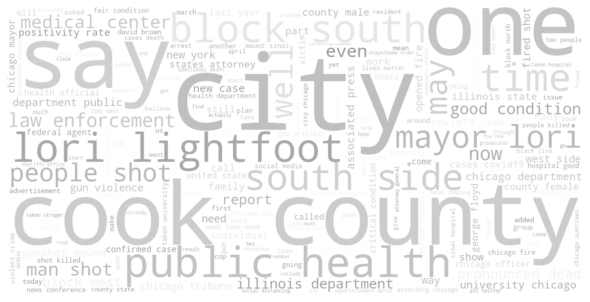

In [ ]:
# create word clodu 
wordcloud = WordCloud(width = 1600, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                random_state=1,
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image 
default_colors = wordcloud.to_array()
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud.recolor(color_func=grey_color_func, random_state=1), interpolation="bilinear")
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [ ]:
# save 
wordcloud.to_file("crime.png")
!cp crime.png "/content/drive/My Drive/"

### Economic Environment Analysis 

#### LDA

In [52]:
# Clean data further excluding stopwards, lemmatizing, removing punctuation

stop = stopwords.words('english')
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()
def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

In [53]:
# clean text column (function in EDA fnction)
economics_df['clean_text'] = [clean(doc).split() for doc in economics_df['text']]

In [55]:
# Create term dictionary of our corpus, where every unique term is assigned an index. 
text_dictionary = corpora.Dictionary(economics_df['clean_text'])

# Convert list of documents (corpus) into Document Term Matrix 
text_term_matrix = [text_dictionary.doc2bow(doc) for doc in economics_df['clean_text']]

In [56]:
# Check number of processors 
num_processors = multiprocessing.cpu_count()
num_processors

2

In [59]:
# fit 5 topic model (eda done earlier but deleted)
%time economics_model5, economics_topics5, economics_display5 = lda_out(text_term_matrix, text_dictionary, 5, 10)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt

CPU times: user 11min 58s, sys: 56.7 s, total: 12min 54s
Wall time: 12min 32s


In [60]:
# show most important words 
economics_topics5

Most important words
Topic Class                                                                                                                                                                           
1                0.011*"chicago" + 0.010*"business" + 0.005*"service" + 0.004*"restaurant" + 0.004*"home" + 0.004*"time" + 0.004*"get" + 0.004*"also" + 0.004*"company" + 0.004*"make"
2            0.008*"business" + 0.008*"company" + 0.006*"experience" + 0.005*"chicago" + 0.005*"service" + 0.005*"work" + 0.005*"new" + 0.004*"customer" + 0.004*"team" + 0.004*"year"
3                 0.031*"tax" + 0.015*"illinois" + 0.014*"state" + 0.010*"income" + 0.008*"share" + 0.008*"company" + 0.007*"million" + 0.007*"billion" + 0.006*"year" + 0.006*"would"
4             0.013*"illinois" + 0.012*"said" + 0.012*"state" + 0.006*"chicago" + 0.005*"election" + 0.005*"people" + 0.004*"trump" + 0.004*"vote" + 0.004*"president" + 0.004*"house"
5                             0.011*"chicago" + 0.006*"year" + 0.005*"team" + 0.005*"game" + 0.005*"season" + 0.004*"said" + 0.004*"one" + 0.004*"new" + 0.004*"player" + 0.004*"bear"

In [61]:
# visualize - notice reasonably sized topics and good spacing 
pyLDAvis.display(economics_display5)

#### Named Entity Recognition

In [ ]:
# Use large pre-trained spacy model 
nlp = spacy.load("en_core_web_lg")

In [ ]:
# Conduct Named Entity Recognition (NER)
entities = []
labels = []

for i in economics_df['text'].tolist():
    doc = nlp(i)
    for ent in doc.ents:
        entities.append(ent.text)
        labels.append(ent.label_)
        
# Total of 454670 entities extracted from article text 
len(entities)

454670

In [ ]:
# preview 
ner_df = pd.DataFrame({'Entities':entities,'Labels':labels})
ner_df.head(20)

Entities    Labels
0                 Capacity       ORG
1      Chicago IP Boutique       ORG
2   Gates Patrick Richards    PERSON
3                McDermott    PERSON
4              Will  Emery    PERSON
5                 KL Gates    PERSON
6                      two  CARDINAL
7                     2009      DATE
8          Erica Silverman    PERSON
9          August 26, 2020      DATE
10                05:58 PM      TIME
11                KL Gates    PERSON
12                Diego M.    PERSON
13                KL Gates       FAC
14                      IP       ORG
15          the Windy City       LOC
16      ALM Digital Reader   PRODUCT
17                 Digital       ORG
18                       3  CARDINAL
19           every 30 days      DATE

In [ ]:
# save csv 
ner_df.to_csv('ner_df_economics.csv')
!cp ner_df_economics.csv "/content/drive/My Drive/"

In [ ]:
# read in data 
ner_df = pd.read_csv('/content/drive/My Drive/ner_df_economics.csv', index_col=0)

In [ ]:
# aggregate categories 
categories = pd.DataFrame(np.unique(ner_df['Labels'], return_counts=True)).T.sort_values(by=1, ascending=False)
categories

0       1
11          ORG  106261
13       PERSON   84839
4           GPE   71834
1          DATE   70309
0      CARDINAL   62115
9          NORP   17857
10      ORDINAL    7209
16         TIME    6900
3           FAC    6116
7           LOC    5749
14      PRODUCT    3208
15     QUANTITY    2375
12      PERCENT    2218
17  WORK_OF_ART    2118
6           LAW    1980
8         MONEY    1745
2         EVENT    1645
5      LANGUAGE     192

In [ ]:
# select relevant entities
entities = ner_df[ner_df.Labels.isin(['ORG',
                                      'PERSON',
                                      'NORP',
                                      'PRODUCT',
                                      'EVENT',
                                      'MONEY',
                                      'LAW'])]
entities['Total'] = 1
entities.head(20)

Entities   Labels  Total
0                     Capacity      ORG      1
1          Chicago IP Boutique      ORG      1
2       Gates Patrick Richards   PERSON      1
3                    McDermott   PERSON      1
4                  Will  Emery   PERSON      1
5                     KL Gates   PERSON      1
8              Erica Silverman   PERSON      1
11                    KL Gates   PERSON      1
12                    Diego M.   PERSON      1
14                          IP      ORG      1
16          ALM Digital Reader  PRODUCT      1
17                     Digital      ORG      1
20                         ALM      ORG      1
21                         ALM      ORG      1
22                       Build  PRODUCT      1
23  Erica Silverman Anna Zhang   PERSON      1
25                       Gates   PERSON      1
27                 Karen Sloan   PERSON      1
31                Max Mitchell   PERSON      1
33                 Jason Zweig   PERSON      1

In [ ]:
# Rename duplicate entities
entities.loc[entities['Entities'].str.contains("Pritzker", na=False, flags=re.I), 'Entities'] = 'Pritzker'
entities.loc[entities['Entities'].str.contains("Facebook", na=False, flags=re.I), 'Entities'] = 'Facebook'
entities.loc[entities['Entities'].str.contains("Lightfoot", na=False, flags=re.I), 'Entities'] = 'Lightfoot'
entities.loc[entities['Entities'].str.contains("COVID", na=False, flags=re.I), 'Entities'] = 'COVID'
entities.loc[entities['Entities'].str.contains("Trump", na=False, flags=re.I), 'Entities'] = 'Trump'
entities.loc[entities['Entities'].str.contains("Tribune", na=False, flags=re.I), 'Entities'] = 'Chicago Tribune'
entities.loc[entities['Entities'].str.contains("Democrat", na=False, flags=re.I), 'Entities'] = 'Democrat'
entities.loc[entities['Entities'].str.contains("Republican", na=False, flags=re.I), 'Entities'] = 'Republican'
entities.loc[entities['Entities'].str.contains("CPS", na=False, flags=re.I), 'Entities'] = 'Chicago Public Schools'

In [ ]:
# aggregate all entities 
entities2 = entities.groupby(['Entities']).sum('Total').sort_values(by='Total', ascending=False)
entities2.head(50)

Total
Entities                   
Democrat               6966
Pritzker               5633
Trump                  4696
Republican             4346
Lightfoot              2338
Biden                  1981
House                  1918
Madigan                1830
Sanders                1200
Joe Biden              1035
Chicago Tribune        1017
Senate                  929
GOP                     844
American                794
COVID                   687
Facebook                672
AP                      631
Congress                611
Twitter                 598
State                   592
Cubs                    557
Illinoisans             523
Welch                   518
Americans               506
Michael Madigan         480
ComEd                   478
Bernie Sanders          475
Bulls                   439
Bears                   438
OwensIllinois           426
Illinois House          356
Newman                  336
Bidens                  329
Lipinski                327
Chicagos                312
the General Assembly    306
Madigans                304
mailin                  288
Amazon                  286
Durbin                  264
the Associated Press    259
Chicagobased            222
LLC                     219
Google                  208
Associated Press        206
Chicagoans              198
Davis                   197
Mike Madigan            195
Chicagoarea             190
Dick Durbin             190

In [ ]:
# create new dataframes 
orgs = entities[entities['Labels']=='ORG'].drop(columns=['Labels']).groupby('Entities').sum().sort_values(by='Total', ascending=False)
person = entities[entities['Labels']=='PERSON'].drop(columns=['Labels']).groupby('Entities').sum().sort_values(by='Total', ascending=False)
norp = entities[entities['Labels']=='NORP'].drop(columns=['Labels']).groupby('Entities').sum().sort_values(by='Total', ascending=False)
product = entities[entities['Labels']=='PRODUCT'].drop(columns=['Labels']).groupby('Entities').sum().sort_values(by='Total', ascending=False)
event = entities[entities['Labels']=='EVENT'].drop(columns=['Labels']).groupby('Entities').sum().sort_values(by='Total', ascending=False)
law = entities[entities['Labels']=='LAW'].drop(columns=['Labels']).groupby('Entities').sum().sort_values(by='Total', ascending=False)
money = entities[entities['Labels']=='MONEY'].drop(columns=['Labels']).groupby('Entities').sum().sort_values(by='Total', ascending=False)

In [ ]:
# top orgs
orgs.head()

Total
Entities              
House             1917
Trump             1455
Chicago Tribune    992
Senate             929
GOP                844

In [ ]:
# top people 
person.head()

Total
Entities        
Pritzker    4502
Trump       3144
Lightfoot   2298
Biden       1981
Madigan     1670

In [ ]:
# top norp
norp.head()

Total
Entities          
Democrat      6091
Republican    3763
American       793
Americans      506
Illinoisans    478

In [ ]:
# top product 
product.head()

Total
Entities       
Trump        80
Excel        64
Companys     51
Notes        39
Cole         32

In [ ]:
# top events 
event.head()

Total
Entities                   
World Series             51
Thanksgiving             41
Super Tuesday            39
Democrat                 32
the Great Depression     31

In [ ]:
# top laws 
law[:50]

Total
Entities                                         
the Illinois Constitution                     118
Constitution                                   71
the Fair Tax                                   59
the Affordable Care Act                        57
Chapter 11                                     51
the First Amendment                            32
the CARES Act                                  32
First Amendment                                32
the Civil Constitution                         32
All Rights Reserved                            31
the U.S. Constitution                          25
the 25th Amendment                             24
CARES Act                                      21
the Defense Production Act                     19
chapter 13                                     18
Fair Tax                                       18
the state constitution                         17
the Fair Tax Amendment                         15
Complete Clean Pledge                          15
Tax Hike Amendment                             15
the Fair Tax amendment                         14
Illinois Amendment                             14
the Lobbyist Registration Act                  12
chapter 7                                      12
Democrat                                       11
Chapter 7                                      11
SB 1639                                        11
Section 21E of the Securities Exchange Act     10
the Second Amendment                           10
the Securities Act                             10
Act                                            10
Section 27A of the Securities Act              10
Copyright 2020                                  9
the Equal Rights Amendment                      9
the state Constitution                          9
the Revenue Article                             9
Second Amendment                                9
chapter 11                                      9
Chapter 13                                      7
Roe v. Wade                                     7
the Heroes Act                                  7
Operation Legend                                6
the Open Meetings Act                           6
the Clean Energy Jobs Act                       6
Redbirds 7471                                   6
the Fair Workweek Ordinance                     6
Trump                                           6
the Constitution                                6
14th Amendment                                  6
Game 5                                          6

In [ ]:
# normalize
law = law.reset_index()
law.loc[law['Entities'].str.contains("Illinois Constitution", na=False, flags=re.I), 'Entities'] = 'Illinois Constitution'
law.loc[law['Entities'].str.contains("Fair Tax", na=False, flags=re.I), 'Entities'] = 'Fair Tax'
law.loc[law['Entities'].str.contains("Tax Hike Amendment", na=False, flags=re.I), 'Entities'] = 'Fair Tax'
law.loc[law['Entities'].str.contains("CARES Act", na=False, flags=re.I), 'Entities'] = 'CARES Act'
law.loc[law['Entities'].str.contains("First Amendment", na=False, flags=re.I), 'Entities'] = 'First Amendment'

In [ ]:
# top laws 
law = law.groupby('Entities').sum().sort_values(by='Total', ascending=False)
law[:10]

Total
Entities                      
Fair Tax                   147
Illinois Constitution      138
Constitution                71
First Amendment             68
CARES Act                   62
the Affordable Care Act     57
Chapter 11                  51
the Civil Constitution      32
All Rights Reserved         31
the U.S. Constitution       25

#### Text Summarization

In [ ]:
# find articles with fair tax or ill constitution 
economics_df[economics_df['text'].str.contains('Illinois Constitution|Fair Tax')][['text']].sample(5)

text
155744  By Vivian La November 4, 2020Gov. J.B. Pritzkers proposed constitutional amendment to implement a graduated income tax system failed to pass on Election Day. The flat tax will remain in the Illinois Constitution.With 98 of precincts reporting as of Wednesday morning, 55 of voters voted No to change the current flat tax rate of 4.95.Even with outstanding mailin ballots, the 55 to 45 in favor is too wide of a margin to overcome. The amendment needed 60 approval in order to pass.Illinois is in a massive budget crisis  a crisis that was only made worse by the Coronavirus pandemic, Vote Yes For Fairness Chairman Quentin Fulks said in a press r...
254671  Illinois Republicans discuss voter empowerment package Posted on February 3, 2021 State Sen. Jason Barickman RBloomington joins fellow Republicans in announcing proposals for voter empowerment. Dave DahlWJBCBy Dave DahlSPRINGFIELD  Voter empowerment is a theme of Illinois Republicans in the legislature now.State Sen. Jason Barickman RBloomington says a package of ideas rolled out Wednesday is in response to frustration.My constituents feel powerless, Barickman told an online news conference, because they feel that the system is stacked against them, so these initiatives and constitutional amendments are designed to empower Illinoisans and...
342141  Gov. Pritzker has no problem hitting up Illinoisans with tax hike after tax hike , but he wont reform one of the richest public sector benefits in the country  Illinois automatic, compounded, 3percent costofliving adjustments for pensions. Skyrocketing pension costs are overwhelming the states finances and COLAs are one of the biggest drivers.COLAs drive up the cost of pensions in Illinois because they double a retirees yearly pension after 25 years. Since the state has nearly 500,000 active workers and beneficiaries who benefit or will benefit from this COLA, its easy to see why the state has racked up nearly 140 billion in officiallyrep...
312358  Illinois has a Fair Tax law on the ballot next month that allegedly will lower taxes for most of the population and raise them on people in the highest tax bracket.What do you think of thisI am still in my 20s and assuming they arent lying to our faces would stand to benefit from this strictly speaking about my paychecks. However they would be taking even more money from my father, who is a corporate finance executive and is already raped six ways to Sunday every year by the tax man. So what should I think of thisAfter working professionally for a while I realized that I should be voting for my own best interest, and not for the interests...
12465   Gov. J.B. Pritzker responds to questions during news conference in Chicago, Aug. 10.Photo: Anthony VazquezAssociated PressIllinois is the nations leading fiscal basket case, with runaway pension liabilities and publicunion control of Springfield. But it has had one saving grace: a flatrate income tax that makes it harder for the political class to raise taxes. Now that last barrier to decline is in jeopardy on the November ballot.The peril comes in a ballot measure backed by Democratic Gov. J.B. Pritzker and his partys supermajority in the Legislature. A yes vote would amend the state constitution to replace the current 4.95 flat levy wit...

In [24]:
# instatiate text transformer 
ts = text.TransformerSummarizer()

In [ ]:
# create variable 
ill_cons = str(economics_df[economics_df['text'].str.contains('Illinois Constitution')]['text'].tolist())

In [ ]:
# summarize 
%time ts.summarize(ill_cons)

CPU times: user 55.2 s, sys: 1.02 s, total: 56.2 s
Wall time: 56.5 s


'Former Chief Justices Ben Miller and Robert Thomas, former Illinois Attorney General Ty Fahner, former U.S. Attorneys Dan Webb and Anton Valukas, and exlllinois House Minority Leader Tom Cross, among others. All of them are Republicans, as is the first name on the list, exGov. Jim Thompson.'

In [ ]:
# create variale 
ill_cons2 = str(economics_df[economics_df['text'].str.contains('Illinois Constitution|Fair Tax')]['text'].tolist())

In [ ]:
# summarize 
%time ts.summarize(ill_cons2)

CPU times: user 2min 1s, sys: 1.75 s, total: 2min 2s
Wall time: 2min 2s


'Justice Thomas Kilbride is up for retention in his west central Illinois district. He won the backing of former Chief Justices Ben Miller and Robert Thomas, former Illinois Attorney General Ty Fahner, former U.S. Attorneys Dan Webb and Anton Valukas, and exlllinois House Minority Leader Tom Cross, among others.'

In [ ]:
# fairtax variable 
fairtax = str(economics_df[economics_df['text'].str.contains('Fair Tax')]['text'].tolist())

In [ ]:
# summarize 
%time ts.summarize(fairtax)

CPU times: user 55.4 s, sys: 561 ms, total: 55.9 s
Wall time: 56 s


'Illinois Democrats used the final day of the Democratic National Convention as a call to action. Delegates say people deserve leaders in the White House who see and hear their concerns. Gov. JB Pritzker even mentioned Americans want a president that takes action to protect their lives and livelihoods.'

In [ ]:
# show articles identifed that are particularly relevant to this project 
final_nli.loc[[111137,297653]][['title','text']]

title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       text
111137       Poor Governance Fuels the Illinois Exodus  Illinois Gov. Jay Robert J. B. Pritzker by Richard W. Porter : Illinois has a population problem: Our population has been shrinking faster than any other state except one. The Chicago Tribune Editorial Board and others call this the Illinois Exodus.Population changes are a measure of governance quality. We are free to choose where to live, and the United States offers 50 different states and thousands of different localities, each governed in different ways. People consider many factors when choosing where to live, and how a state is governed can be a significant factor in that decision. Over time, people migrate toward places that are go...
297653  Best  Worst States: Business Drain in Illinois  The state has lost 850,000 people over the past decade, and risks becoming known as the California of the Midwest. By  June 10, 2020The piece below is part of Chief Executive s annual Best  Worst States for Business ranking. Read the full report . Some Illinois leaders worry that their state is resembling two things these days: California and a coronavirus patient in critical condition. Concerns include an attempt to get voters to approve a graduatedincometax constitutional amendment and that a Covid19induced recession could exacerbate Illinois deficiencies, such as the Chicago public school system. The governor has sold this vote as a ta...

#### TFIDF Document Similarity

In [ ]:
# find ordered index value to match with tfidf matrix 
final_nli['idx_2'] = np.arange(len(final_nli))
final_nli.loc[[297653]]['idx_2']

297653    137758
Name: idx_2, dtype: int64

In [ ]:
# instantiate and fit TFIDF vectorizer 
text_content = final_nli['text']
vector = TfidfVectorizer(max_df=0.3,         # drop words that occur in more than X percent of documents
                             min_df=8,      # only use words that appear at least X times
                             stop_words='english', # remove stop words
                             lowercase=True, # Convert everything to lower case 
                             use_idf=True,   # Use idf
                             norm=u'l2',     # Normalization
                             smooth_idf=True # Prevents divide-by-zero errors
                            )
tfidf = vector.fit_transform(text_content)

In [ ]:
# function to find similar : get the top_n articles similar to an article 
def find_similar(tfidf_matrix, index, top_n = 5):
    cosine_similarities = linear_kernel(tfidf_matrix[index:index+1], tfidf_matrix).flatten()
    related_docs_indices = [i for i in cosine_similarities.argsort()[::-1] if i != index]
    return [index for index in related_docs_indices][0:top_n]    

In [ ]:
# find most similar for first aricle 
result = find_similar(tfidf, 137758, top_n = 7)
article_1_sim = final_nli[final_nli.idx_2.isin(result)][['title','text']]

In [ ]:
# find index value 
final_nli.loc[[111137]]['idx_2']

111137    32
Name: idx_2, dtype: int64

In [ ]:
# find most similar to second article 
result2 = find_similar(tfidf, 32, top_n = 7)
article2_sim = final_nli[final_nli.idx_2.isin(result2)][['title','text']]

In [ ]:
# show all similar articles to exodus-related articles 
exit_df = pd.concat([article2_sim, article_1_sim], join='inner') 
exit_df

title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       text
371945                                                                  Poor Governance Fuels that the Illinois Exodus  Illinois has a population problem: Our population has been shrinking faster than any other state except one. The Chicago Tribune Editorial Board and others call this the Illinois Exodus. Population changes are a measure of governance quality. We are free to choose where to live, and the United States offers 50 different states and thousands Post author No Comments on Poor Governance Fuels that the Illinois ExodusIllinois has a people problem: Our population has been decreasing faster than any other nation except one. The Chicago Tribune Editorial Board and others call this the Illinois Exodus.Population changes are a step of governance qu...
25789                                     Commentary: Illinois exodus problem is a governance problem  Chicago Tribune  Commentary: Illinois exodus problem is a governance problem By Richard Porter Chicago Tribune  Aug 07, 2020 at 11:23 AM Illinois has been losing population. U.S. census data currently being collected nationally will show whether that trend continues. Charlie Neibergall  AP Illinois has a population problem: Our population has been shrinking faster than any other state except one. The Chicago Tribune Editorial Board and others call this the Illinois Exodus . Population changes are a measure of governance quality. We are free to choose where to live, and the United States offers 50 states and thousands of different localities, each governed...
304323                                             An Overview of the Proposed Illinois Graduated Income Tax Amendment  A few other notable items in the proposal include: The property tax credit would increase from 5 to 6 A child tax credit of 100 per child may be implemented with phaseouts beginning at 40,000 for singleincome households Corporate taxes would increase from a flat 7 to a flat 7.95 for a total of 10.45 including personal property replacement tax Why the changeAs many residents are aware, Illinois has been struggling to balance its budget for years due to its unpaid bills and unfunded public employee pension liability. The COVID19 pandemic has only accelerated these problems. Switching to a graduated income tax increases the states flexibilit...
3225                                                         ILLINOIS STATE, LOCAL TAX BURDEN RANKED HIGHEST IN NATION  Tuesday, April 21, 2020 ILLINOIS STATE, LOCAL TAX BURDEN RANKED HIGHEST IN NATION This Fat Bastard is looking for a bailout because Democrats SUCK at running economies. Look at Illinois. Illinois residents pay more of their income toward state and local taxes than any other states residents. A progressive income tax proposal on the ballot in November would raise the states total tax burden by 3.7 billion. Families in Illinois again carry a heavier tax load than anywhere else in the United States, but the survey showing that also finds a significant willingness by taxpayers to lighten that load by moving  or getting a tattoo. Illinois resi...
121864                                                                     Illinois Has 9th Highest Tax Burden in U.S.                                                                                   Illinois has among the highest tax burdens of all states, acco

In [ ]:
# save all articles as a list 
exit_str = str(exit_df['text'].tolist())

In [ ]:
# summarize 
%time ts.summarize(exit_str)

CPU times: user 27.7 s, sys: 212 ms, total: 27.9 s
Wall time: 28 s


'Illinois has a population problem: Our population has been shrinking faster than any other state except one. Population changes are a measure of governance quality. Over time, individuals migrate toward areas that are governed well and away from regions that are regulated badly. Gov. J.B. Pritzker and House Speaker Michael Madigan are working together to amend the state constitution to increase the tax burden.'

### Leisure Analysis

#### Sentiment Analysis 

In [ ]:
# show sample of leisure articles 
leisure_df[['text']].sample(5)

text
268623  Looking for a Chicago DP  Owner Operator, with Sony FS7 or FS9  for studio interview in Chicago Please dont reply unless you are a hands on Sony FS7 DPOP Must be available  Tuesday, August 11th, 2020 Please send link to reel with interview and studio work. All COVID protocols will be followed All crew must wear appropriate COVID PPE All crew will be expected to sign COVID questionnaire Interview Host will be in Chicago studio  Guest will be remote in NYC studio. We will record internally  but run HDMI signal out to laptop to ZOOM image to remote guest  directors in Atlanta Camera will roll for 1 hour with talent. Then breakdown and leave....
177352  You wont believe what Illinois favorite fastfood french fry is Aug 27, 2020  David PWhen it comes to the best fastfood French fries, opinions across the U.S. differ. Spruce , a company that produces CBD products, recently analyzed Google Trends data to determine the most popular fast food fries and most popular style of French fries in each state.They found that McDonalds fries took the top spot in 16 states, geographically spread out across the country, while Burger King and Taco Bell were tied in second place with six states each even though Taco Bell nacho fries were recently pulled from its menu. Arbys and Popeyes took the hearts and ...
343476                                                                                                                                                                                                                                                                                                                                   Been awhile since I done one of these, Ask anything related to Chicago or its gangs and rappers and I will answer to the best of my ability. Incriminating questions and questions about who killed who will not be answered. Ask away  also please try to refrain from asking questions that have already been asked in previous rounds
224635  Illinois Games Board Collection agencies Suggestions With respect to Casinos Towards ReopenIllinois Games Board Collection agencies Suggestions With respect to Casinos Towards ReopenIn view of the fact that the particular online casino in just success attract location for on line on line casino online games, a lot of dramatis personae starting wayramikuna.com up available the globe currently have get piece in just them. Potential clients that have analyze to get started some other consideration to promise these salutation reward provide you with ever again may well become arrested for an excellent quick club and then may quite possibly ou...
284967  Usually on the Wednesday following the Fest for Beatle Fans in Chicago I would write up a review of my weekend. Since we live in a crazy time right now, the Fest was canceled. Then a virtual Fest was scheduled.I had my doubts about having a virtual Fest. I will be honest with you all. I thought spending 44 actually 48 when you added in the fees was ridiculous. I had watched other virtual events, including the NKOTB virtual cruise, and it didnt cost a thing. I wasnt sure if I could justify spending that much money on something online. And even now I am not sure about the price, but I will overlook that for now.The virtual Fest went above a...

In [ ]:
# load large spacy 
nlp = spacy.load("en_core_web_lg")

In [ ]:
# split articles into sentences 
%time leisure_df["text2"] = leisure_df["text"].apply(lambda x: [sent.text for sent in nlp(x).sents])

CPU times: user 20min 21s, sys: 18 s, total: 20min 39s
Wall time: 20min 40s


In [ ]:
# save to csv 
leisure_df.to_csv('leisure_df.csv')

!cp leisure_df.csv "/content/drive/My Drive/"

In [ ]:
# create new row for each sentence 
%time leisure_sentence = leisure_df.explode("text2", ignore_index=False)

CPU times: user 243 ms, sys: 56 ms, total: 299 ms
Wall time: 310 ms


In [ ]:
# resulted in 578,937 rows 
len(leisure_sentence)

578937

In [ ]:
# preview 
leisure_sentence.head()

crime  ...                                                                                                                                                       text2
48810  0.826778  ...                                                                    admin Corruption , Democrats , Left Wing Extremists Leave a comment Like us on Facebook:
48810  0.826778  ...                                                                                         Beetlejuice Lori Lightfoot stands with the left wing terrorist mob.
48810  0.826778  ...  After left wing terrorists tried to topple the Grant Park Columbus status, bue were eventually turned away by police, Lori Lightfoot did the job for them.
48810  0.826778  ...                                                          She had the Columbus statue removed in the middle of the night while most people slept in Chicago.
48810  0.826778  ...                                                                  It was about this time last week when the left wing terrorists tried to remove the statue.

[5 rows x 19 columns]

In [ ]:
# create classes, functions for sentiment analysis (positive cases only)
ABSTAIN = -1
Other = 1

@preprocessor(memoize=True)
def textblob_sentiment(x):
    scores = TextBlob(x.text2)
    x.polarity = scores.sentiment.polarity
    x.subjectivity = scores.sentiment.subjectivity
    return x

@labeling_function(pre=[textblob_sentiment])
def textblob_polarity(x):
    return Other if x.polarity > 0.9 else ABSTAIN

@labeling_function(pre=[textblob_sentiment])
def textblob_subjectivity(x):
    return Other if x.subjectivity >= 0.7 else ABSTAIN

In [ ]:
# fit
lfs = [textblob_polarity, textblob_subjectivity]

applier = PandasLFApplier(lfs)
L_train = applier.apply(leisure_sentence)

LFAnalysis(L_train, lfs).lf_summary()

100%|██████████| 578937/578937 [07:53<00:00, 1223.18it/s]


j Polarity  Coverage  Overlaps  Conflicts
textblob_polarity      0      [1]  0.006631  0.003216        0.0
textblob_subjectivity  1      [1]  0.101232  0.003216        0.0

In [ ]:
# save df with positive sentiment 
pos_leisure_snorkel = leisure_sentence.iloc[L_train[:, 0] == Other]

In [ ]:
# save
pos_leisure_snorkel.to_csv('positive_sentiment.csv')
!cp positive_sentiment.csv "/content/drive/My Drive/"

In [25]:
# read in 
pos_leisure_snorkel = pd.read_csv('/content/drive/My Drive/positive_sentiment.csv', index_col=0)

In [26]:
# 3839 positive sentences 
len(pos_leisure_snorkel)

3839

In [27]:
# preview 
pos_leisure_snorkel[['title','text','text2']].sample(30)

title  ...                                                                                                                                                                                                  text2
7330                                                                                                             Chicago YC Verve Cup Preview  ...                                                                                                                       An excellent turnout of Jsailors will be participating in this weekends regatta.
141582                                                    Oswegos Little White School Museum earns two Illinois Association of Museums awards  ...                                               The museum also took home a best practices Award of Merit in the COVID Response category for their online Toys from the Attic Christmas holiday exhibit.
60887                                                          Why YoYo Ma spent years with Civic Orchestra: To change young lives in Chicago  ...  One of the things that I think people are very proud of is the Civic started doing a Bach Marathon project every fall leading into the holiday season, where they play all six Brandenburg Concertos.
265757                                                                  Illinois Householders: Suggestions To Establish A Kitchen area Island  ...                                                                   For help building the excellent kitchen area island make contact with a HomeAdvisor style and design and remodel expert in Illinois.
237852                                                                                       The Greatest Guide To Bellami Extensions Chicago  ...                                                                                   To me, the perfectly livedin waves that I fastidiously blew out, curled, and coiffed every day made me feel like me.
292550                                                                                                            LOSING THE BLUES IN CHICAGO  ...                                                                                                                                                              Our team had a wonderful show in Chicago.
160082                                                                                                               Girls weekend in Chicago  ...                                                                                                                                               James, Ive ever encountered nnWe had a wonderful weekend
65014                                      Illinois Video game titles Board Choices Guidelines Designed for Online casinos To help you Reopen  ...                                                                                                                                                                        Three about the perfect style  
90630                                                                      Freddie Banks  Piano Keyboards Synths  Organ  Chicago  SoundBetter  ...                                                                                                                                                                       are especially proud of and why.
90285                                           Meet Chicagoarea native Drew Sidora, the newest cast member of The Real Housewives of Atlanta  ...                                                                                                                                                                                      That was awesome.
34743                                                                                         The Greatest Guide To Chicago PD dvd Seasons 16  ...                                                                                                                                                        The Greatest Guide To Chicago PD

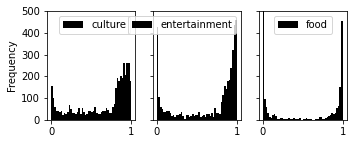

In [28]:
# visualize distribution for each type of leisure 
pos_leisure_snorkel[['culture','entertainment','food']].plot.hist(subplots=True, 
                                           bins=50, 
                                           figsize=(30,2), 
                                           color='black', 
                                           grid=False, 
                                           sharey=True, 
                                           ylim=(0,500), 
                                           layout=(1,16)
                                           );

In [29]:
# preview results for articles most relevant to food 
pos_food = pos_leisure_snorkel[(pos_leisure_snorkel['food']>=pos_leisure_snorkel['culture']) & (pos_leisure_snorkel['food']>=pos_leisure_snorkel['entertainment'])]
print(len(pos_food))
pos_food.sample(10)

783


crime  ...                                                                                                                                                                 text2
162544  0.006767  ...                                                                                                                                 Been owning some very good sleep too.
195242  0.014477  ...                                                                                                                          Our greatest means of protection is prayer .
267529  0.002205  ...     As the COVID19 situation continues to escalate in the US and around the world, we are committed to keeping our teams and their families as our greatest priority.
260739  0.004541  ...                                                                                                                                         Delicious Chocolate Avalanche
211640  0.000937  ...                                                                                         We just got the tallies done, and that would be considered a very good yield.
262492  0.001084  ...                                                               Brunch, not quite breakfast nor lunch, is one of the best parts of the weekend  even during a pandemic.
333194  0.000433  ...                                                                                                                                             and youve got the perfect
13365   0.006503  ...                                                                              Tehina Hummus and Pita BreadI would say that the brisket itself was the best part of it.
76375   0.000404  ...  Though I think Robert Siegerdt, who sent wonderful photos of a sea of ramps in the north suburbs, captured the feeling well with this observation: An awesome field.
126014  0.016637  ...                                                                                                                         That is a very fair question, Lightfoot said.

[10 rows x 19 columns]

In [64]:
# summarize one example 
food_ex = str(final_nli.loc[[333194]][['text']])
%time ts.summarize(food_ex)

CPU times: user 1.19 s, sys: 212 ms, total: 1.4 s
Wall time: 1.4 s


'Dining in Chicago is one of our strongest areas, but with so many options to choose from, it can be hard to pick a spot. We made the decision easier for you by narrowing down a list to some of the top restaurants in Chicago. The selection at Little Bad Wolf is to die for.Located in Wicker Park, ettas woodfire style cooking is the perfect addition to their innovative menu.'

In [62]:
# preview results for articles most relevant to culture 
pos_culture = pos_leisure_snorkel[(pos_leisure_snorkel['culture']>=pos_leisure_snorkel['food']) & (pos_leisure_snorkel['culture']>=pos_leisure_snorkel['entertainment'])]
print(len(pos_culture))
pos_culture.sample(10)

1195


crime  ...                                                                                                                                                                                                  text2
38563   0.000509  ...                                                               AP File PhotoWith a frenetic defense dominating the backcourt, Bachs dogged coaching style perfectly complemented Jacksons zen approach.
126331  0.001581  ...                                                         Rustic wedding chic has brought you the best hand picked rustic wedding venues and locations in illinois to help you plan the perfect wedding.
28473   0.004081  ...                                                                                                   They provide Party Bus Chicago and are known for being one of the best Limousine Service in Chicago.
79533   0.016525  ...                                                                                                                                              I used to be real proud of the fact that I would have 50.
12492   0.271105  ...                                                                                    Stone Creek on North State Street is excellent, and its steaks obtain rave opinions from locals and visitors alike.
144290  0.007950  ...                                                                                                                                     The signature room and lounge provide an awesome view of the city.
245098  0.000921  ...                                                                                                                     What do you feel is your greatest accomplishment to dateMy greatest accomplishment
344839  0.000571  ...  YoYo Ma and KenDavid Masur, after the Dvorak cello concerto After the concert concluded, Ma gave another encore piece, but not before making one of the greatest speeches Ive heard in Orchestra Hall
49394   0.000598  ...                                                                                                                                  How did one of the greatest dynasties of all time come together Heres
136550  0.971825  ...                                                               Pippen, at 2.78 million per season, was making just a 112 of that, even though he was one of the best players in the league at the time.

[10 rows x 19 columns]

In [63]:
# summarize relevant article 
cult_ex = str(final_nli.loc[[144290]][['text']])
%time ts.summarize(cult_ex)

CPU times: user 1 s, sys: 193 ms, total: 1.19 s
Wall time: 1.44 s


'The summer is the best time to visit, because you can fully take advantage of Lake Michigan, exploring the city and the Chicago river on foot. The winter is still full of things to do including Broadway and comedy shows, ice skating at Millennium park or Maggie Daley, or the Kris Kringle Xmas market.'

In [67]:
# preview results for articles most relevant to leisure  
pos_ent = pos_leisure_snorkel[(pos_leisure_snorkel['entertainment']>=pos_leisure_snorkel['culture']) & (pos_leisure_snorkel['entertainment']>=pos_leisure_snorkel['food'])]
print(len(pos_ent))
pos_ent.sample(10)

1861


crime  ...                                                                                                                                                                                                       text2
105498  0.000433  ...                                                                                                                  Please connect with WEDO, a wonderful resource to find inspiration and tangible takeaways.
287592  0.002792  ...                                                                                                                                                                                          Best of NFL Nation
267698  0.001366  ...                                                                                                                                                                                         Best Birthday Party
197827  0.000416  ...                                                              While were continuing to feature destinations that make our state wonderful, we dont expect or encourage you to go check them out immediately.
50314   0.002421  ...                                                                                                                                                            His ended playing with the greatest of all time.
130289  0.005450  ...                                                                                                                               It is one of the best microblading service in Chicago and surroundings areas.
143852  0.000968  ...                                                                                                                              Patti Vasquez Patti is a nationally touring headliner and one of comedys best.
277132  0.079405  ...  Plus, when it comes time to remind everyone hes a sixtime NBA Champion and twotime Olympic gold medalist, a custom indoor basketball court awaits to be graced by one of the greatest players of all time:
290692  0.000491  ...                                                                                                           Skating through the ribbon with Americas greatest city all around you is absolutely breathtaking.
123404  0.006148  ...                                                                             I had seen in her in Creed a while ago and was very impressed with her, and when I saw she was in this, I decided to watch it  

[10 rows x 19 columns]

In [70]:
# summarize relevant example for entertainment 
ent_ex = str(final_nli.loc[[3746]][['text']])
#ent_ex = str(final_nli.loc[[290692]][['text']])
%time ts.summarize(ent_ex)

CPU times: user 941 ms, sys: 172 ms, total: 1.11 s
Wall time: 1.11 s


'Among the highlighted songs in the show are I Made the Match Myself, Should We Ever Meet, Pride and Sense, Stranger Things Have Happened and Have a Piece of Cake. Chicago Shakespeare Theater has a hit on its hands with this show. Fans of Austens stories as well as music fans, in g...'

In [ ]:
# define functions for negative sentiment analysis 
ABSTAIN = -1
Other = 1

@preprocessor(memoize=True)
def textblob_sentiment(x):
    scores = TextBlob(x.text2)
    x.polarity = scores.sentiment.polarity
    x.subjectivity = scores.sentiment.subjectivity
    return x

@labeling_function(pre=[textblob_sentiment])
def textblob_polarity(x):
    return Other if x.polarity < -0.6 else ABSTAIN

@labeling_function(pre=[textblob_sentiment])
def textblob_subjectivity(x):
    return Other if x.subjectivity >= 0.5 else ABSTAIN

In [ ]:
# fit 
lfs = [textblob_polarity, textblob_subjectivity]

applier = PandasLFApplier(lfs)
L_train = applier.apply(leisure_sentence)

LFAnalysis(L_train, lfs).lf_summary()

100%|██████████| 578937/578937 [07:58<00:00, 1210.97it/s]


j Polarity  Coverage  Overlaps  Conflicts
textblob_polarity      0      [1]  0.003667  0.003543        0.0
textblob_subjectivity  1      [1]  0.256354  0.003543        0.0

In [ ]:
# save negative results 
neg_leisure_snorkel = leisure_sentence.iloc[L_train[:, 0] == Other]

In [ ]:
# save 
neg_leisure_snorkel.to_csv('negative_sentiment.csv')
!cp negative_sentiment.csv "/content/drive/My Drive/"

In [41]:
# read in df 
neg_leisure_snorkel = pd.read_csv('/content/drive/My Drive/negative_sentiment.csv', index_col=0)

In [42]:
# 2123 negative sentences 
len(neg_leisure_snorkel)

2123

In [43]:
# sample
neg_leisure_snorkel[['text2']].sample(20)

text2
355357                                                                                                                                                                                                           My teeth hurt really bad.
217224                                                                                                                                                                                                 I never had a bad scene with a cop.
48214                                                             In the face of Trump sending in troops to Chicago, Mayor Bad Ass goes out like a bish and relents to pressure to remove Christopher Columbus statues across the city....
237685                                                                                         Have you always desired to try hair extensions but have been too afraid to devote With the media mentioning celebs with bad hair extensions
308794                                                                                                                                                                 Bettors can grab the Cubs to score just one run at insane 100 odds.
275033                                                                                                                                                                         The mix is so compressed that its downright claustrophobic.
358669  You have to have someone they trust, like an influencer, just delivering the message, she recalled the expert telling her, citing the Holocaust as one reason that some Jews are fearful of government interference and overreach.
10450                                                                                                                                                                 I was around during John F. Kennedy time in office I didnt hate him.
332145                                                                                                                                                                                    How very difficult this must have been for them.
38080                                                              Landlords are upset because the No Eviction, law puts them in a bad position because they still have to pay taxes, gas, water, etc., and all without any incoming rent.
313905                                                                                                                                                                                                                               Awful
367149                                                                                                                                                                                                 I am infuriated and I am disgusted.
9685                                                                                                                                                                               Wednesday was the bloody catharsis, Thursday was farce.
156821                                                                                                                                           Flipboard DJ Steward, the SunTimes Player of the Year, doesnt have a tragic origin story.
96030                                                                                                                            As a result of that, Ive been finding it very difficult to find episode 1, which I still havent seen yet.
216580                                                                                                   How are people also fearful about doing that and afraid of doing that and also these ideas of safety and security versus freedom.
7857                                                                                                                       and, you know, not be hurting so bad at the end of the summer, said Anthony Chin, Chinatown Square Association.

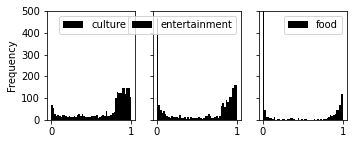

In [46]:
# visualzie 
neg_leisure_snorkel[['culture','entertainment','food']].plot.hist(subplots=True, 
                                           bins=50, 
                                           figsize=(30,2), 
                                           color='black', 
                                           grid=False, 
                                           sharey=True, 
                                           ylim=(0,500), 
                                           layout=(1,16)
                                           );